# Parameter Inference with SNe dataset - Understand selection effects



In [2]:
import numpy as np
import pandas as pd
import emcee
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid, trapezoid
from scipy.interpolate import interp1d
from chainconsumer import Chain, ChainConsumer, ChainConfig, Truth
from IPython.display import display, Math
import multiprocessing as mp
from multiprocessing import Pool
import math


## Cosmological Models & Likelihoods

In [3]:
### Models and cosmological quantities ###

def d_L(h, z, o_m, o_l, o_k=None, **kwargs):
    """Calculate Luminosity distance for given cosmological parameters.

    Parameters
    ----------
    h : int or np.array
        hubble parameter 
    z : np.array
        redshift 
    o_m : int
        Omega_m 
    o_l : int
        Omega_Lambda
    o_k : int
        Omega_k
    w : int (optional)
        DE EOS parameter 
        
    Returns
    -------
    d_L : np.array
        Luminosity distance
    """

    o_r = 9.e-5
    if o_k is None:
        o_k = 1 - o_m - o_l - o_r
    elif o_k == 0:
        o_l = 1 - o_m - o_r

    w = kwargs.get('w', None)

    # Hubble distance
    d_H = 2997.92458/h
    
    # Comoving Distance
    if w == None:
        d_C = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4  )
        d_C = cumulative_trapezoid(d_C(o_m, o_l, o_k), z, initial=0)
    else:
        d_C = lambda omega_m, omega_lambda, omega_k, w, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda * (1 + z)**(3 * (1 + w)) + omega_r * (1+z)**4)
        d_C = cumulative_trapezoid(d_C(o_m, o_l, o_k, w), z, initial=0)
    d_C[np.isnan(d_C)] = 0
    
    # Transverse comoving distance:
    omega_k = o_k
    if omega_k > 0:
        d_M = d_H * (1/np.sqrt(omega_k)) * np.sinh((np.sqrt(omega_k) * d_C) / d_H) 
    if omega_k == 0:
        d_M = d_C
    if omega_k < 0:
        d_M = d_H * (1/np.sqrt(-omega_k)) * np.sin((np.sqrt(-omega_k) * d_C) / d_H) 

    # Luminosity Distance
    d_L = (1 + z) * d_M
    return d_L

def distance_modulus(h, z, omega_m, omega_l, omega_k=None, **kwargs):
    """ Calculate distance modulus """
    w = kwargs.get('w', None)
    dl = d_L(h, z, omega_m, omega_l, omega_k, w=w)
    dis_mod = 5 * np.log10(dl) + 25
    return dis_mod

def chi_square(y_model, y, yerr):
    """ Calculate chi-square for individual data"""
    p = (y - y_model)**2/(yerr)**2
    return p 

def cov_chi_square(y_model, y, inv_cov):
    """ Calculate chi-square using covariance matrix"""
    diff = y - y_model
    chi2 = np.dot(diff.T , np.dot(inv_cov, diff))
    return chi2

In [16]:
### Likelihoods ###

# Chi-Square Log-Likelihood | Omega_m vs Omega_Lambda (Fixed h) | Open Lambda CDM
def log_likelihood_om_m_vs_om_l_fixed_h_open_lCDM(theta, data):
    omega_m, omega_l = theta
    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()
    h = 0.7
    z = np.linspace(0, 2, 1000)
    
    model1 = distance_modulus(h, z, omega_m, omega_l)
    func_model1 = interp1d(z, model1)
    model2 = func_model1(z_array)
    chi2 = chi_square(model2, mag_array, mag_err)
    chi2 = np.sum(chi2)
    return -chi2/2 

# Chi-Square Log-Likelihood | Omega_m vs Omega_Lambda vs h | Open Lambda CDM
def log_likelihood_h_vs_om_m_vs_om_l_open_lCDM(theta, data):
    h, omega_m, omega_l = theta
    if h==0:
        return -np.inf
    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)
    
    model1 = distance_modulus(h, z, omega_m, omega_l)
    func_model1 = interp1d(z, model1)
    model2 = func_model1(z_array)
    chi2 = chi_square(model2, mag_array, mag_err)
    chi2 = np.sum(chi2)

    return -chi2/2 

# Chi-Square Log-Likelihood | Omega_m vs Omega_Lambda vs h vs w | Open wCDM
def log_likelihood_h_vs_om_m_vs_om_l_vs_w_open_wCDM(theta, data):
    h, omega_m, omega_l, w = theta

    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)

    model1 = distance_modulus(h, z, omega_m, omega_l, w=w)
    func_model1 = interp1d(z, model1)
    model2 = func_model1(z_array)
    chi2 = chi_square(model2, mag_array, mag_err)
    chi2[np.isnan(chi2)] = np.inf

    chi2 = np.sum(chi2)
    #print(chi2)
    # Add a regularization term to penalize extreme values of omega_lambda and w
    #penalty = 0.01 * (omega_l - 0.7)**2 + 0.01 * (w + 1.0)**2
    
    return -(chi2)/2

# Chi-Square Log-Likelihood | Omega_M vs w (fixed h) | Flat wCDM
def log_likelihood_om_m_vs_w_fixed_h_flat_wCDM(theta, data):
    omega_m, w = theta

    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)
    
    model1 = distance_modulus(0.7, z, omega_m, 0, 0, w=w)
    func_model1 = interp1d(z, model1)
    model2 = func_model1(z_array)
    chi2 = chi_square(model2, mag_array, mag_err)
    chi2 = np.sum(chi2)
    return -chi2/2 

# Covariance Matrix Chi-Square Log-Likelihood | Omega_M vs Omega_Lambda | Fixed h | Open lambda CDM 
def log_likelihood_covariance_om_m_vs_om_l_fixed_h_open_lCDM(theta, data, inv_cov):
    # Unpack parameters
    omega_m, omega_l = theta
    
    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    #cov_mat = cov_mat.to_numpy()
    #print('cov shape', cov_mat.shape)
    #cov_mat[np.isnan(cov_mat)] = 0

    h = 0.7
    z = np.linspace(0, 2, 1000)
    
    model1 = distance_modulus(h, z, omega_m, omega_l)
    func_model1 = interp1d(z, model1)
    model2 = func_model1(z_array)
    chi2 = cov_chi_square(model2, mag_array, inv_cov)
    #chi2[np.isnan(chi2)] = np.inf

    return -chi2/2

# Covariance Matrix Chi-Square Log-Likelihood | h vs Omega_M vs Omega_Lambda | Fixed h | Open lambda CDM 
def log_likelihood_covariance_h_vs_om_m_vs_om_l_open_lCDM(theta, data, inv_cov):
    # Unpack parameters
    h, omega_m, omega_l = theta
    
    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)
    
    model1 = distance_modulus(h, z, omega_m, omega_l)
    func_model1 = interp1d(z, model1)
    model2 = func_model1(z_array)
    chi2 = cov_chi_square(model2, mag_array, inv_cov)
    #chi2[np.isnan(chi2)] = np.inf

    return -chi2/2

# Marginalized Chi-Square Log-Likelihood (over h) | Omega_M | Flat Lambda CDM 
def marginalized_log_likelihood_om_m_flat_lCDM(theta, data):
    """ Flat universe """
    omega_m = theta

    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)
    #h = np.linspace(0.68, 0.72, 1000)

    # Marginalize over H0
    
    om_k = 0
    om_r = 9.e-5
    om_l = 1 - omega_m - om_r - om_k

    #d_H = 2997.92458/h
    #A = 5 * np.log10(d_H)

    int1 = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : 1/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4)
    int1 = cumulative_trapezoid(int1(omega_m, om_l, om_k), z, initial=0)
    func = interp1d(z, int1)
    int1 = func(z_array)

    B = (5 * np.log10((1 + z_array) * int1)) + 25

    f1 = 0.5 * np.sum(1 / (mag_err ** 2))
    f2 = np.sum((B - mag_array) / (mag_err ** 2))
    f3 = 0.5 * np.sum(((B - mag_array) ** 2 )/ (mag_err ** 2))

    chi2_marginalized = (2 * f3) - (f2**2 / (2 * f1))
    
    #integrand = lambda f1, f2, f3, A: np.exp(f3 + (A * f2) + (f1 * A * A))

    marginalized_likelihood = np.exp(-0.5 * chi2_marginalized)#trapezoid(integrand(f1, f2, f3, A), h)    
    return np.log(marginalized_likelihood)

# Marginalized Chi-Square Log-Likelihood (over h) | Omega_M vs w | Flat wCDM
def marginalized_log_likelihood_om_m_vs_w_flat_wCDM(theta, data):
    """ Flat universe """
    omega_m, w = theta

    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)
    #h = np.linspace(0.68, 0.72, 1000)


    # Marginalize over H0
    
    om_k = 0
    om_r = 9.e-5
    om_l = 1 - omega_m - om_r - om_k

    #d_H = 2997.92458/h
    #A = 5 * np.log10(d_H)

    int1 = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : 1/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda * (1 + z)**(3 * (1 + w)) + omega_r * (1+z)**4)
    int1 = cumulative_trapezoid(int1(omega_m, om_l, om_k), z, initial=0)
    func = interp1d(z, int1)
    int1 = func(z_array)

    B = (5 * np.log10((1 + z_array) * int1)) + 25

    f1 = 0.5 * np.sum(1 / (mag_err ** 2))
    f2 = np.sum((B - mag_array) / (mag_err ** 2))
    f3 = 0.5 * np.sum(((B - mag_array) ** 2 )/ (mag_err ** 2))

    chi2_marginalized = (2 * f3) - (f2**2 / (2 * f1))
    
    #integrand = lambda f1, f2, f3, A: np.exp(f3 + (A * f2) + (f1 * A * A))

    marginalized_likelihood = np.exp(-0.5 * chi2_marginalized)#trapezoid(integrand(f1, f2, f3, A), h)    
    return np.log(marginalized_likelihood)

# Marginalized Covariance Matrix Chi-Square Log-Likelihood (over h) | Omega_M | Flat Lambda CDM
def marginalized_log_likelihood_covariance_om_m_flat_lCDM(theta, data, inv_cov):
    """ Flat universe """
    omega_m = theta

    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    n = mag_array.size
    #mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)
    #h = np.linspace(0.65, 0.75, n) ### prior

    # Marginalize over H0
    
    om_k = 0
    om_r = 9.e-5
    om_l = 1 - omega_m - om_r - om_k

    #d_H = 2997.92458/h
    #A = - 5 * np.log10(h)

    int1 = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : 1/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4)
    int1 = cumulative_trapezoid(int1(omega_m, om_l, om_k), z, initial=0)
    func = interp1d(z, int1)
    int1 = func(z_array)

    B = (5 * np.log10((1 + z_array) * int1)) + 25 + (5 * np.log10(2997.92458))

    one = np.ones(n)
    f1 = np.dot(one.T, np.dot(inv_cov, one))
    f2 = - 2 * np.dot(one.T, np.dot(inv_cov, (mag_array - B)))
    f3 = np.dot((mag_array - B).T, np.dot(inv_cov, mag_array - B))

    chi2_marginalized = f3 - (f2**2 / (4 * f1))

    #integrand = lambda f1, f2, f3, A: np.exp(-0.5 * ((f1 * A * A) + (f2 * A) + f3))

    #marginalized_likelihood = trapezoid(integrand(f1, f2, f3, A), h)   
    marginalized_likelihood = np.exp(- 0.5 * chi2_marginalized)

    #marginalized_likelihood = np.sqrt((2*np.pi)/f1) * np.exp((f2**2 / (2*f1)) - (f3/2)) # this is integrated wrt A not h
    return np.log(marginalized_likelihood)

# Marginalized Covariance Matrix Chi-Square Log-Likelihood (over h) | Omega_M vs w | Flat wCDM
def marginalized_log_likelihood_covariance_om_m_vs_w_flat_wCDM(theta, data, inv_cov):
    """ Flat universe """
    omega_m, w = theta

    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    n = mag_array.size
    #mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)
    #h = np.linspace(0.65, 0.75, n) ### prior

    # Marginalize over H0
    
    om_k = 0
    om_r = 9.e-5
    om_l = 1 - omega_m - om_r - om_k

    #d_H = 2997.92458/h
    #A = - 5 * np.log10(h)

    int1 = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : 1/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda * (1 + z)**(3 * (1 + w)) + omega_r * (1+z)**4)
    int1 = cumulative_trapezoid(int1(omega_m, om_l, om_k), z, initial=0)
    func = interp1d(z, int1)
    int1 = func(z_array)

    B = (5 * np.log10((1 + z_array) * int1)) + 25 + (5 * np.log10(2997.92458))

    f1 = np.dot(np.ones_like(mag_array).T, np.dot(inv_cov, np.ones_like(mag_array)))
    f2 = - 2 * np.dot(np.ones_like(mag_array).T, np.dot(inv_cov, (mag_array - B)))
    f3 = np.dot((mag_array - B).T, np.dot(inv_cov, mag_array - B))

    #integrand = lambda f1, f2, f3, A: np.exp(-0.5 * ((f1 * A * A) + (f2 * A) + f3))
    chi2_marginalized = f3 - (f2**2 / (4 * f1))

    marginalized_likelihood = np.exp(- 0.5 * chi2_marginalized) #trapezoid(integrand(f1, f2, f3, A), h)   

    #marginalized_likelihood = np.sqrt((2*np.pi)/f1) * np.exp((f2**2 / (2*f1)) - (f3/2)) # this is integrated wrt A not h
    return np.log(marginalized_likelihood)



### Other Useful Functions

In [5]:
def plot_emcee_chains_and_histograms(samples, sampler, labels, discard=500, thin=10, flat=True, sys=False):
    """
    Plots the MCMC walker chains and posterior histograms for the parameters.
    
    Parameters:
    - samples: Array of shape (nwalkers, nsteps, ndim) containing the MCMC samples.
    - sampler: The emcee sampler object used to get the chain.
    - labels: List of parameter names corresponding to each dimension.
    - discard: Number of initial steps to discard from each chain (burn-in).
    - thin: Step size for thinning the chain.
    - flat: If True, flattens the chain across all walkers.
    
    Returns:
    - None. Plots are shown.
    """
    ndim = len(labels)  # Number of parameters (dimensions)
    
    # Plot the walker chains for each parameter
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)  # Plot the chain for each parameter
        ax.set_ylabel(labels[i])
    axes[-1].set_xlabel("Step number")
    plt.show()

    # Flatten the chain (remove burn-in and combine walkers)
    flat_samples = sampler.get_chain(discard=discard, thin=thin, flat=flat)
    
    # Plot histograms of the posterior samples
    plt.figure(figsize=(10, 5))
    for i in range(ndim):
        plt.hist(flat_samples[:, i], bins=30, alpha=0.6, label=labels[i])
    plt.xlabel("Parameter value")
    plt.legend()
    if sys:
        plt.title("With sytematics")
    else:
        plt.title("Without systematics")
    plt.show()
    
    return flat_samples

## Dataset

In [6]:
# SNe Data
# Union2
df = pd.read_csv("SCPUnion2_mu_vs_z.txt", sep="\t", header=None, names=["object_name", "redshift", "magnitude", "error_magnitude"], skiprows=5)
#print('Union2 Dataset: \n', df)

# Union2.1
#df = pd.read_csv("SCPUnion2.1_mu_vs_z.txt", sep="\t", header=None, names=["object_name", "redshift", "magnitude", "error_magnitude"], skiprows=5)
df

object_name  redshift  magnitude  error_magnitude
0        1993ah  0.028488  35.335551         0.226144
1        1993ag  0.050043  36.675442         0.167114
2         1993o  0.052926  36.816881         0.155866
3         1993b  0.070086  37.440321         0.158669
4        1992bs  0.062668  37.480331         0.156270
..          ...       ...        ...              ...
552      2001gn  1.124000  44.576403         0.198691
553      2001go  0.552000  42.530251         0.105933
554      2001gq  0.671000  42.991417         0.121927
555      2001gy  0.511000  42.388163         0.089912
556      2001hb  1.030000  44.251656         0.142161

[557 rows x 4 columns]

In [7]:
# Without systematics

# Union2.1
cov_mat_nosys = pd.read_csv("SCPUnion2_covmat_nosys.txt", sep="\t", header=None)

# Union2.1
#cov_mat_nosys = pd.read_csv("SCPUnion2.1_covmat_nosys.txt", sep="\t", header=None)

del cov_mat_nosys[cov_mat_nosys.columns[-1]]
cov_mat_nosys = cov_mat_nosys.to_numpy()

try:
    inv_cov_nosys = np.linalg.inv(cov_mat_nosys)
except np.linalg.LinAlgError:
    raise ValueError("Covariance matrix is singular or not invertible")

#df["magnitude"].to_numpy().shape
print(cov_mat_nosys.shape)

(557, 557)


In [8]:
# with systematics
# Union2
cov_mat_sys = pd.read_csv("SCPUnion2_covmat_sys.txt", sep="\t", header=None)

# Union2.1
#cov_mat_sys = pd.read_csv("SCPUnion2.1_covmat_sys.txt", sep="\t", header=None)

del cov_mat_sys[cov_mat_sys.columns[-1]]
cov_mat_sys = cov_mat_sys.to_numpy()

try:
    inv_cov_sys = np.linalg.inv(cov_mat_sys)
except np.linalg.LinAlgError:
    raise ValueError("Covariance matrix is singular or not invertible")

#df["magnitude"].to_numpy().shape
cov_mat_sys.shape

(557, 557)

### Testing Bias

In [16]:
### Cuts ###

# Malmquist Bias
# All mags in range 30-50 mags
# Any magnitude > 44.0 is removed from the sample

malm_cut = 43.5
filtered_df = df[df['magnitude'] <= malm_cut]
print(filtered_df)

# No. of SNe lost
loss = len(df) - len(filtered_df)
print('No. of SNe lost =', loss)

    object_name  redshift  magnitude  error_magnitude
0        1993ah  0.028488  35.335551         0.226144
1        1993ag  0.050043  36.675442         0.167114
2         1993o  0.052926  36.816881         0.155866
3         1993b  0.070086  37.440321         0.158669
4        1992bs  0.062668  37.480331         0.156270
..          ...       ...        ...              ...
546      2003bd  0.670000  43.155027         0.186583
547      2003be  0.640000  42.910421         0.186745
553      2001go  0.552000  42.530251         0.105933
554      2001gq  0.671000  42.991417         0.121927
555      2001gy  0.511000  42.388163         0.089912

[495 rows x 4 columns]
No. of SNe lost = 62


/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_52235/3008668361.py:64: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25


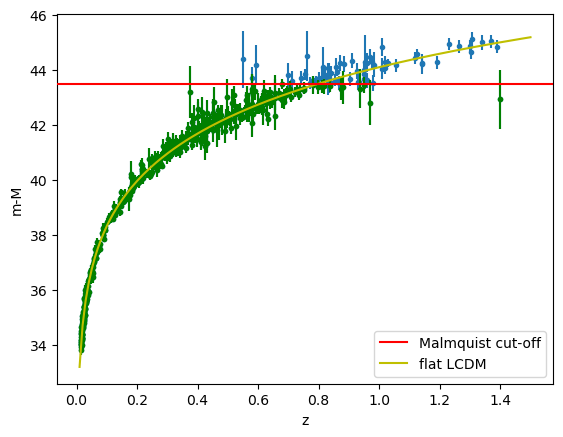

In [124]:
plt.errorbar(df['redshift'], df['magnitude'], yerr=df['error_magnitude'], fmt='.', zorder=1)
plt.errorbar(filtered_df['redshift'], filtered_df['magnitude'], yerr=filtered_df['error_magnitude'], fmt='.', color='green', zorder=2)#, alpha=0.5)
plt.axhline(y = malm_cut, color = 'r', linestyle = '-', zorder=4, label='Malmquist cut-off') 
#plt.xscale('log')
plt.xlabel("z")
plt.ylabel("m-M")

# Model Universe: omega_M ~ 0.3, Omega_Lambda ~ 0.7
z_array = df['redshift'].to_numpy()
x = np.linspace(0, 1.5, 150)
flat_matter_cosmo = distance_modulus(0.7, x, 0.3, 0.69)
#test = distance_modulus(0.704, x, 0.59, 1.09)  ## Constraints from Truncated Data
#func_flat_matter_cosmo = interp1d(x, flat_matter_cosmo)
#flat_matter_cosmo = func_flat_matter_cosmo(df['redshift'])
plt.plot(x, flat_matter_cosmo, '-y' ,label='flat LCDM', zorder=3)
#plt.plot(x, test, '-b' ,label='Biased Fit', zorder=5)

plt.legend(loc='lower right')

#### Modify the data to account for KN with viewing angle dependency   (INCORRECT!)
Consider that the SNe data is actually KNe data with all head on magnitudes of the KNe. 

Let us introduce some noise or random increase in magnitudes from original values to make them look like KNe that are not viewed head on but at some angle

In [190]:
'''head_on_mag = func_flat_matter_cosmo(df['redshift'])
head_on_mag

#if df['magnitude'] > head_on_mag:
#    new_mag = df['magnitude'] + 0.5
kn_df = df
#[df['magnitude'] > head_on_mag]
#kn_df.loc[kn_df['redshift'] > head_on_mag, 'redshift'] += 0.5
#kn_df['magnitude'] += (kn_df['magnitude'] > head_on_mag) * 0.5

# Generate random values between 0 and 1 for each row
#random_values = np.random.uniform(0.0, 0.2, size=len(kn_df))
#kn_df.loc[kn_df['magnitude'] > head_on_mag, 'magnitude'] += random_values[kn_df['magnitude'] > head_on_mag]
#kn_df += random_values[kn_df['magnitude'] > head_on_mag]

noise = np.random.uniform(0.0, 3.0, len(kn_df))
#kn_df['magnitude'] += noise
kn_df.loc[kn_df['magnitude'] > head_on_mag, 'magnitude'] += noise[kn_df['magnitude'] > head_on_mag]
kn_df'''

"head_on_mag = func_flat_matter_cosmo(df['redshift'])\nhead_on_mag\n\n#if df['magnitude'] > head_on_mag:\n#    new_mag = df['magnitude'] + 0.5\nkn_df = df\n#[df['magnitude'] > head_on_mag]\n#kn_df.loc[kn_df['redshift'] > head_on_mag, 'redshift'] += 0.5\n#kn_df['magnitude'] += (kn_df['magnitude'] > head_on_mag) * 0.5\n\n# Generate random values between 0 and 1 for each row\n#random_values = np.random.uniform(0.0, 0.2, size=len(kn_df))\n#kn_df.loc[kn_df['magnitude'] > head_on_mag, 'magnitude'] += random_values[kn_df['magnitude'] > head_on_mag]\n#kn_df += random_values[kn_df['magnitude'] > head_on_mag]\n\nnoise = np.random.uniform(0.0, 3.0, len(kn_df))\n#kn_df['magnitude'] += noise\nkn_df.loc[kn_df['magnitude'] > head_on_mag, 'magnitude'] += noise[kn_df['magnitude'] > head_on_mag]\nkn_df"

In [191]:
'''# Malmquist Bias
# All mags in range 30-50 mags
# Any magnitude > 44.0 is removed from the sample

malm_cut = 44.25
new_filtered_df = kn_df[kn_df['magnitude'] <= malm_cut]
print(new_filtered_df)

# No. of SNe lost
loss2 = len(kn_df) - len(new_filtered_df)
print('No. of SNe lost =', loss2)

print(" KNe lost due to viewing angle dependency ", loss2-loss)'''

'# Malmquist Bias\n# All mags in range 30-50 mags\n# Any magnitude > 44.0 is removed from the sample\n\nmalm_cut = 44.25\nnew_filtered_df = kn_df[kn_df[\'magnitude\'] <= malm_cut]\nprint(new_filtered_df)\n\n# No. of SNe lost\nloss2 = len(kn_df) - len(new_filtered_df)\nprint(\'No. of SNe lost =\', loss2)\n\nprint(" KNe lost due to viewing angle dependency ", loss2-loss)'

In [192]:
'''plt.errorbar(kn_df['redshift'], kn_df['magnitude'], yerr=kn_df['error_magnitude'], fmt='.', zorder=1)
#plt.errorbar(new_filtered_df['redshift'], new_filtered_df['magnitude'], yerr=new_filtered_df['error_magnitude'], fmt='.', color='green', zorder=2)#, alpha=0.5)
plt.axhline(y = malm_cut, color = 'r', linestyle = '-', zorder=4, label='Malmquist cut-off') 
#plt.xscale('log')
plt.xlabel("z")
plt.ylabel("m-M")

# Model Universe: omega_M ~ 0.3, Omega_Lambda ~ 0.7
z_array = kn_df['redshift'].to_numpy()
x = np.linspace(0, 1.5, 150)
flat_matter_cosmo = distance_modulus(0.7, x, 0.3, 0.69)
flat_matter_cosmo = distance_modulus(0.12, x, 0.47, -0.11)

#func_flat_matter_cosmo = interp1d(x, flat_matter_cosmo)
#flat_matter_cosmo = func_flat_matter_cosmo(df['redshift'])
plt.plot(x, flat_matter_cosmo, '-y' ,label='flat LCDM', zorder=3)
plt.legend(loc='lower right')'''

'plt.errorbar(kn_df[\'redshift\'], kn_df[\'magnitude\'], yerr=kn_df[\'error_magnitude\'], fmt=\'.\', zorder=1)\n#plt.errorbar(new_filtered_df[\'redshift\'], new_filtered_df[\'magnitude\'], yerr=new_filtered_df[\'error_magnitude\'], fmt=\'.\', color=\'green\', zorder=2)#, alpha=0.5)\nplt.axhline(y = malm_cut, color = \'r\', linestyle = \'-\', zorder=4, label=\'Malmquist cut-off\') \n#plt.xscale(\'log\')\nplt.xlabel("z")\nplt.ylabel("m-M")\n\n# Model Universe: omega_M ~ 0.3, Omega_Lambda ~ 0.7\nz_array = kn_df[\'redshift\'].to_numpy()\nx = np.linspace(0, 1.5, 150)\nflat_matter_cosmo = distance_modulus(0.7, x, 0.3, 0.69)\nflat_matter_cosmo = distance_modulus(0.12, x, 0.47, -0.11)\n\n#func_flat_matter_cosmo = interp1d(x, flat_matter_cosmo)\n#flat_matter_cosmo = func_flat_matter_cosmo(df[\'redshift\'])\nplt.plot(x, flat_matter_cosmo, \'-y\' ,label=\'flat LCDM\', zorder=3)\nplt.legend(loc=\'lower right\')'

### Saved Results

Using SCP Union2 Original Data with systematics

| Type of Sampling | Other Information | Type of $\chi^2$ | Likelihood | Samples | 
|:--------:|:--------:|:--------:|:--------:|:--------:|
|  $\Omega_M$ vs $\Omega_\Lambda$        |  Open $\Lambda$ CDM   |  Simple $\chi^2$      | Full Likelihood (Delta prior on h) | omega_m_omega_l-curved_universe_EMCEE.csv |
|  |  |  Covariance $\chi^2$ (no sys)  | Full Likelihood (Delta prior on h) | omega_m_omega_l-curved_universe_EMCEE_covariance_nosys.csv |
|  |  |  Covariance $\chi^2$ (sys)  | Full Likelihood (Delta prior on h) | omega_m_omega_l-curved_universe_EMCEE_covariance_sys.csv |
|  $h$ vs $\Omega_M$ vs $\Omega_\Lambda$   | Open Universe         |  Simple $\chi^2$      | Full Likelihood | h_omega_m_omega_l-curved_universe_EMCEE.csv|
|  |  |  Covariance $\chi^2$ (no sys)    | Full Likelihood | h_omega_m_omega_l-curved_universe_EMCEE_covariance_nosys.csv|
|  |  |  Covariance $\chi^2$ (sys)    | Full Likelihood | h_omega_m_omega_l-curved_universe_EMCEE_covariance_sys.csv|
|  $\Omega_M$   |  Flat $\Lambda$ CDM  | Simple $\chi^2$ | Marginalized Likelihood (over h) | omega_m-flat_universe_EMCEE_marginalized.csv|
| | | Covariance $\chi^2$ (no sys)| Marginalized Likelihood (over h) | omega_m-flat_universe_EMCEE_marginalized_covariance_nosys.csv |
| | | Covariance $\chi^2$ (sys)| Marginalized Likelihood (over h) | omega_m-flat_universe_EMCEE_marginalized_covariance_sys.csv |
| $\Omega_M$ vs $\omega$ | Flat $\omega$ CDM | Simple $\chi^2$ | Full Likelihood (Delta prior on h) | w_omega_m-EMCEE_strict_prior.csv |
| | | Simple $\chi^2$ | Marginalized Likelihood (over h) | w_omega_m-EMCEE_marginalized.csv |
| | | Covariance $\chi^2$ (no sys) | Marginalized Likelihood (over h) | w_omega_m-EMCEE_marginalized_covariance_nosys.csv |
| | | Covariance $\chi^2$ (sys) | Marginalized Likelihood (over h) | w_omega_m-EMCEE_marginalized_covariance_sys.csv |
| $h$ vs $\Omega_M$ vs $\Omega_\Lambda$ vs $\omega$ | Open $\omega$ CDM |  Simple $\chi^2$ | Full likelihood | h_omega_m_omega_l_w-EMCEE_open_wCDM.csv |

Using Truncated Data
| Type of Sampling | Other Information | Type of $\chi^2$ | Likelihood | Samples | 
|:--------:|:--------:|:--------:|:--------:|:--------:|
|  $h$ vs $\Omega_M$ vs $\Omega_\Lambda$   | Open Universe         |  Simple $\chi^2$      | Full Likelihood | Malmquist_Bias-h_omega_m_omega_l-curved_universe_EMCEE.csv|


# Samplings

## Full Dataset

### $\Omega_M$ vs $\Omega_\Lambda$ (Open $\Lambda$ CDM ) 

#### Simple $\chi^2$ 

In [14]:
def log_prior(theta):
    omega_m, omega_l = theta
    if 0.0 < omega_m < 0.5 and 0.4 < omega_l < 1.0:  # Prior for sigma must be positive
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_om_m_vs_om_l_fixed_h_open_lCDM(theta, data)

In [19]:
data = df

# Number of dimensions (h, omega_m, omega_l)
ndim = 2

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 6

# Initial positions of the walkers (random guesses)
initial_omega_m = np.random.uniform(0.2, 0.4, nwalkers)  # Omega_m
initial_omega_l = np.random.uniform(0.6, 0.8, nwalkers)

pos = np.array([initial_omega_m, initial_omega_l]).T  # Shape (nwalkers, 3)

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])

In [20]:
# Run the MCMC for 500 steps
nsteps = 100000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_52235/3008668361.py:64: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
100%|██████████| 100000/100000 [02:09<00:00, 775.18it/s]


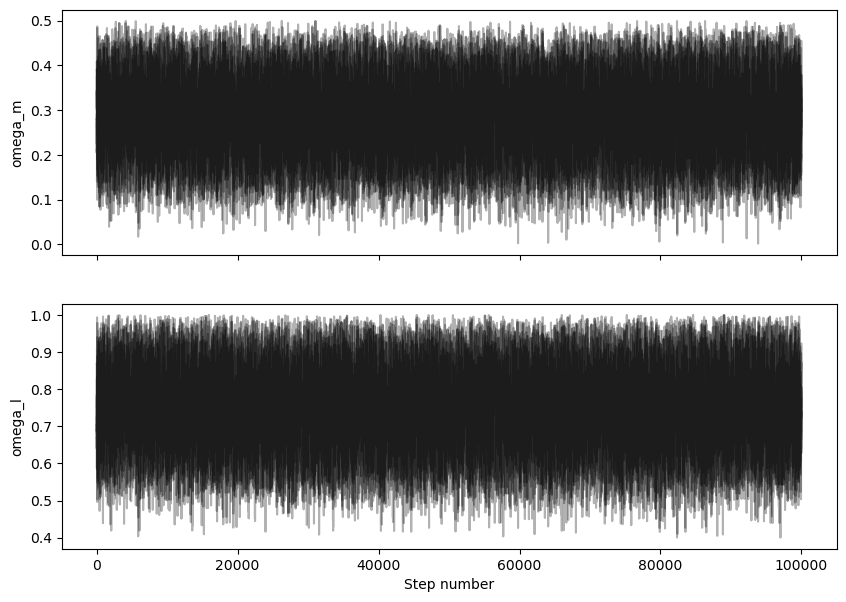

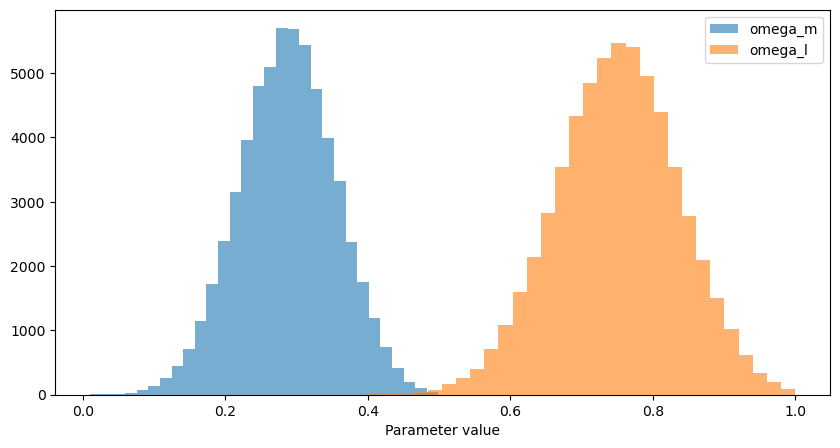

In [27]:
labels = [ "omega_m", "omega_l"]
flat_samples = plot_emcee_chains_and_histograms(samples, sampler, labels)

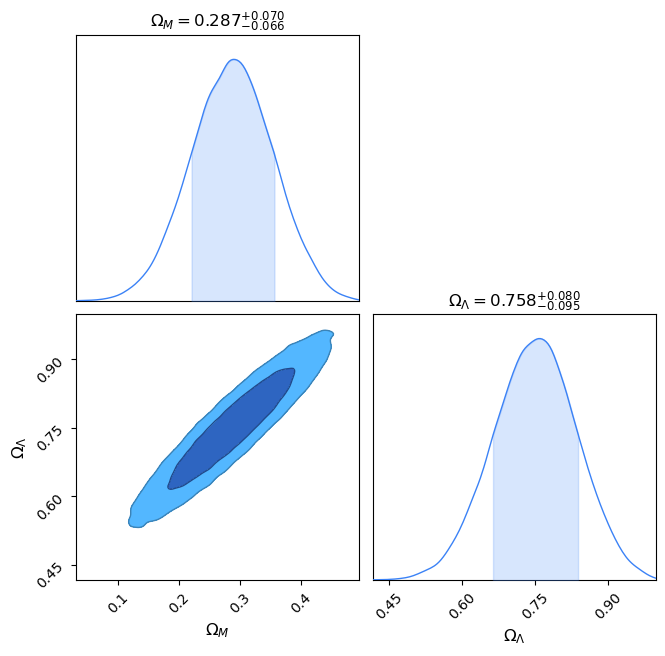

In [28]:
df1 = pd.DataFrame(flat_samples, columns = ['$\Omega_M$', '$\Omega_\Lambda$'])
c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour"))
fig = c.plotter.plot()

In [29]:
### SAVE RESULTS ####
df1.to_csv("omega_m_omega_l-curved_universe_EMCEE.csv", index=False)

#### Covariance $\chi^2$

In [70]:
def log_prior(theta):
    omega_m, omega_l = theta
    if 0.0 < omega_m < 1.0 and 0.2 < omega_l < 2.0:  # Prior for sigma must be positive
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

def log_posterior(theta, data, inv_cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_covariance_om_m_vs_om_l_fixed_h_open_lCDM(theta, data, inv_cov)

In [71]:
data = df

# Number of dimensions (h, omega_m, omega_l)
ndim = 2

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 6

# Initial positions of the walkers (random guesses)
#initial_guesses = np.random.rand(nwalkers, ndim)
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m
initial_omega_l = np.random.uniform(0.65, 0.75, nwalkers)      # w

# Combine initial positions into one array (for 3 parameters)
pos = np.array([ initial_omega_m, initial_omega_l]).T  # Shape (nwalkers, 3)

# Set up the sampler object
# No systematics
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, inv_cov_nosys])

# With systematics
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, inv_cov_sys])

In [72]:
# Run the MCMC for 500 steps
nsteps = 100000
sampler1.run_mcmc(pos, nsteps, progress=True)
sampler2.run_mcmc(pos, nsteps, progress=True)


# Get the samples from the sampler chain
samples1 = sampler1.get_chain()
samples2 = sampler2.get_chain()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_93644/3008668361.py:64: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [19:57<00:00, 83.50it/s] 


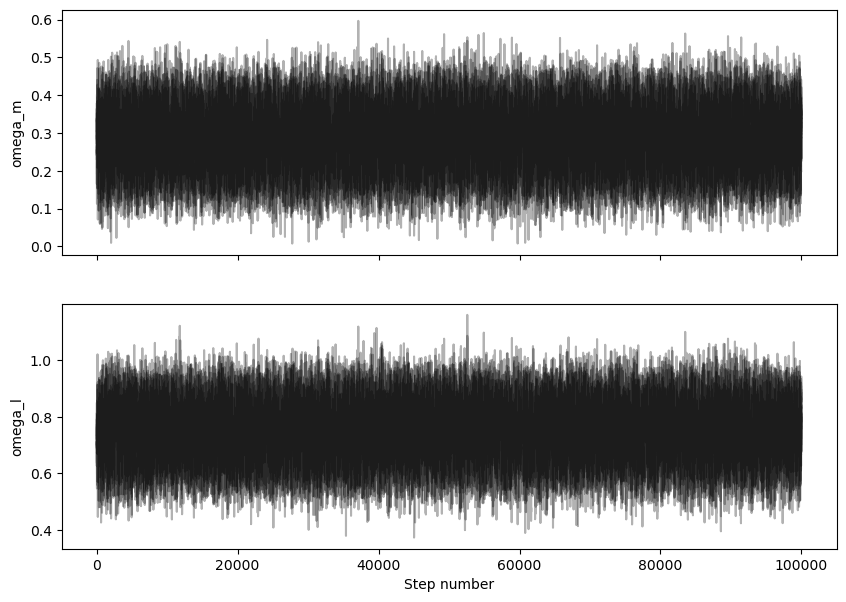

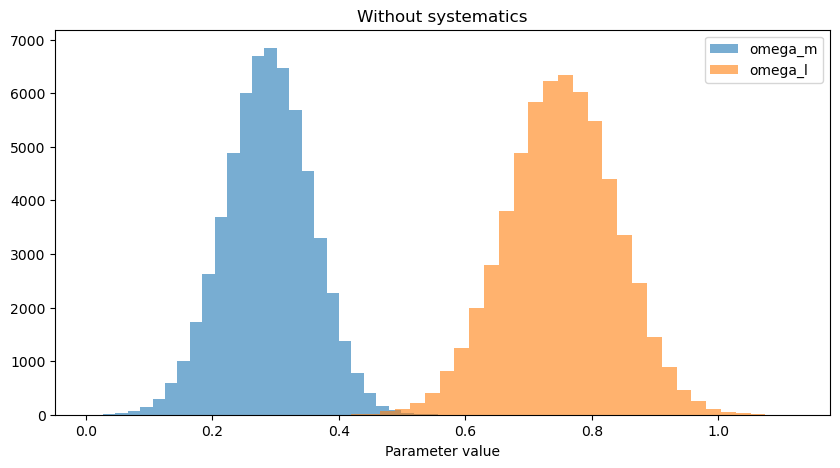

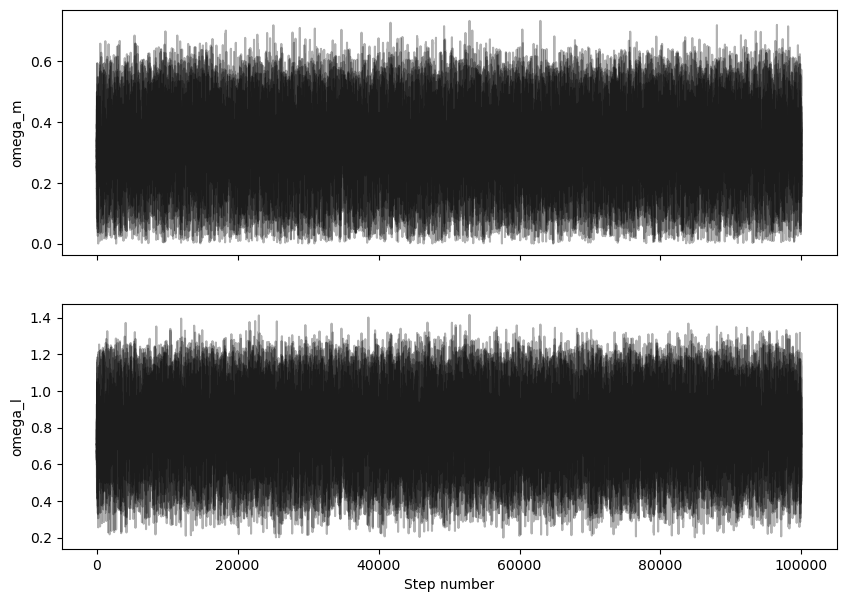

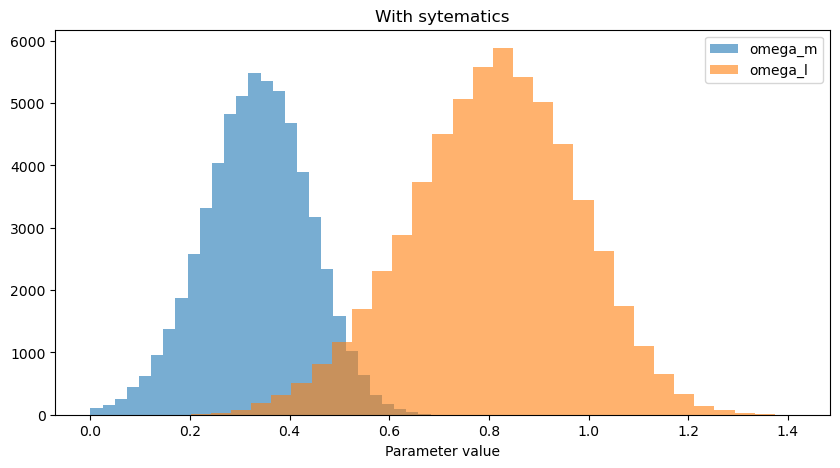

In [73]:
labels = [ "omega_m", "omega_l"]
flat_samples1 = plot_emcee_chains_and_histograms(samples1, sampler1, labels, sys=False)
flat_samples2 = plot_emcee_chains_and_histograms(samples2, sampler2, labels, sys=True)

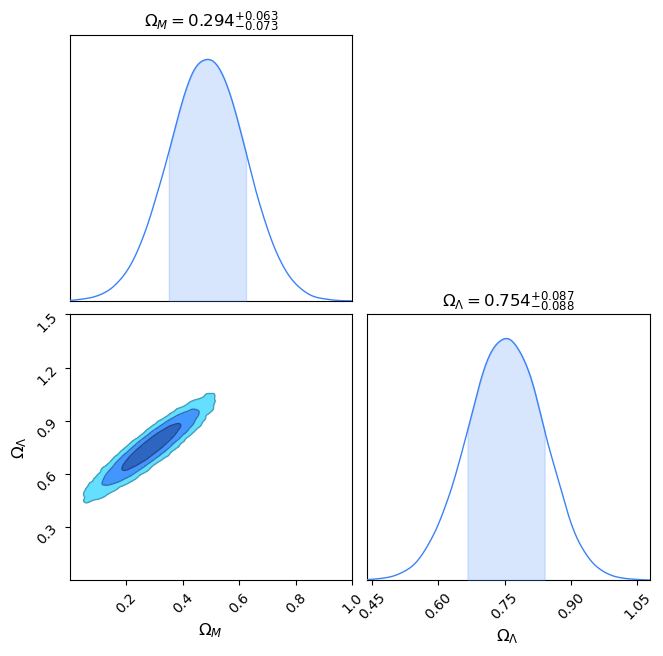

In [74]:
df_1 = pd.DataFrame(flat_samples1, columns = ['$\Omega_M$', '$\Omega_\Lambda$'])
df_2 = pd.DataFrame(flat_samples2, columns = ['$\Omega_M$', '$\Omega_\Lambda$'])

c = ChainConsumer()
c.add_chain(Chain(samples=df_1, name="Without systematics", show_contour_labels=False))
c.set_override(ChainConfig(sigmas=[0, 1, 2, 3]))

fig = c.plotter.plot()

# Customize the axis limits using matplotlib's set_xlim and set_ylim
ax = fig.axes[2]  # Access the first subplot
ax.set_ylim(0.0, 1.5)  # Set limits for the second parameter
ax.set_xlim(0.0, 1.0)  # Set limits for the second parameter


# Optional: Save or show the plot
plt.show()

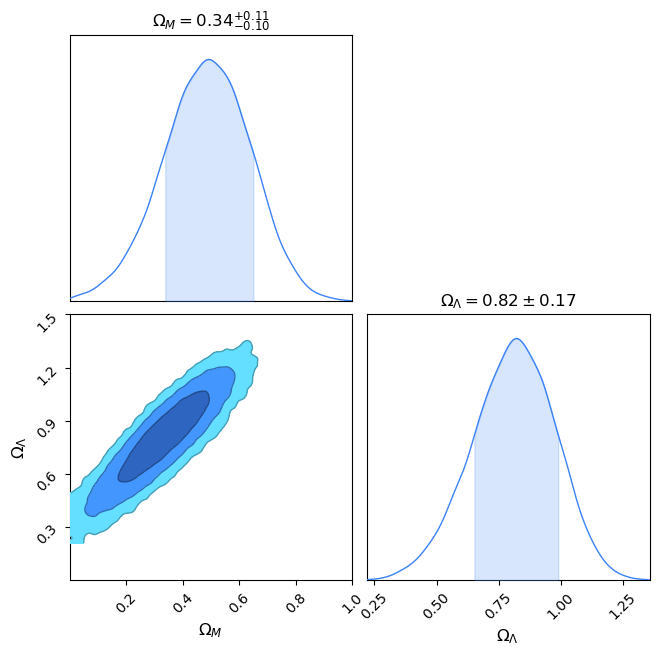

In [75]:
c = ChainConsumer()
c.add_chain(Chain(samples=df_2, name="With systematics", show_contour_labels=False))
c.set_override(ChainConfig(sigmas=[0, 1, 2, 3]))

fig = c.plotter.plot()

# Customize the axis limits using matplotlib's set_xlim and set_ylim
ax = fig.axes[2]  # Access the first subplot
ax.set_ylim(0.0, 1.5)  # Set limits for the second parameter
ax.set_xlim(0.0, 1.0)  # Set limits for the second parameter


# Optional: Save or show the plot
plt.show()

In [57]:
### SAVE RESULTS ####
df_1.to_csv("omega_m_omega_l-curved_universe_EMCEE_covariance_nosys.csv", index=False)
df_2.to_csv("omega_m_omega_l-curved_universe_EMCEE_covariance_sys.csv", index=False)

### $h$ vs $\Omega_M$ vs $\Omega_\Lambda$  (Open $\Lambda$ CDM ) 


#### Simple $\chi^2$

In [59]:
def log_prior(theta):
    h, omega_m, omega_l = theta
    if 0.5 < h < 0.8 and 0.0 < omega_m < 0.5 and 0.4 < omega_l < 2.0:  # Prior for sigma must be positive
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_h_vs_om_m_vs_om_l_open_lCDM(theta, data)

In [46]:
data = df

# Number of dimensions (h, omega_m, omega_l)
ndim = 3

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 9

# Initial positions of the walkers (random guesses)
initial_h = np.random.uniform(0.6, 0.8, nwalkers)  # Omega_m
initial_omega_m = np.random.uniform(0.2, 0.4, nwalkers)  # Omega_m
initial_omega_l = np.random.uniform(0.6, 0.8, nwalkers)

pos = np.array([initial_h, initial_omega_m, initial_omega_l]).T  # Shape (nwalkers, 3)

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])

In [47]:
# Run the MCMC for 500 steps
nsteps = 100000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_52235/3008668361.py:64: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
100%|██████████| 100000/100000 [03:00<00:00, 553.69it/s]


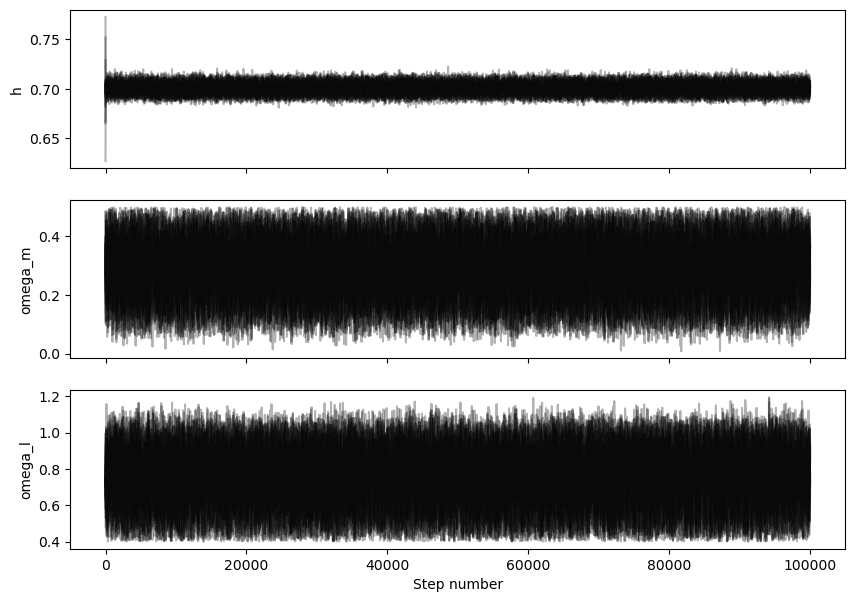

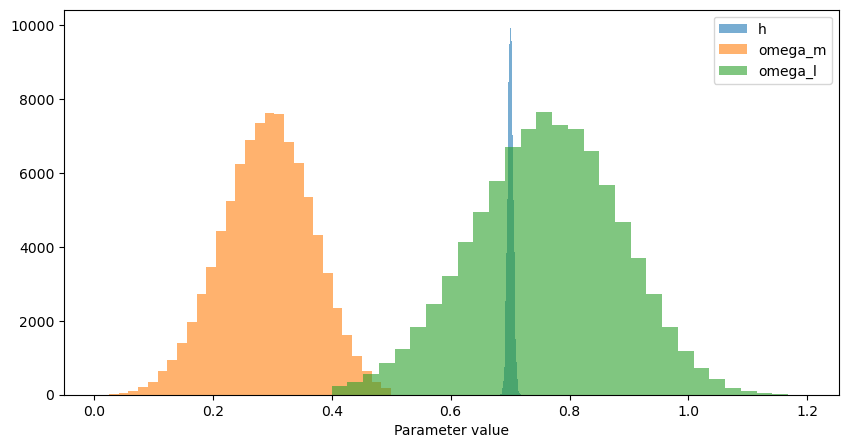

In [48]:
labels = [ "h", "omega_m", "omega_l"]
flat_samples = plot_emcee_chains_and_histograms(samples, sampler, labels)

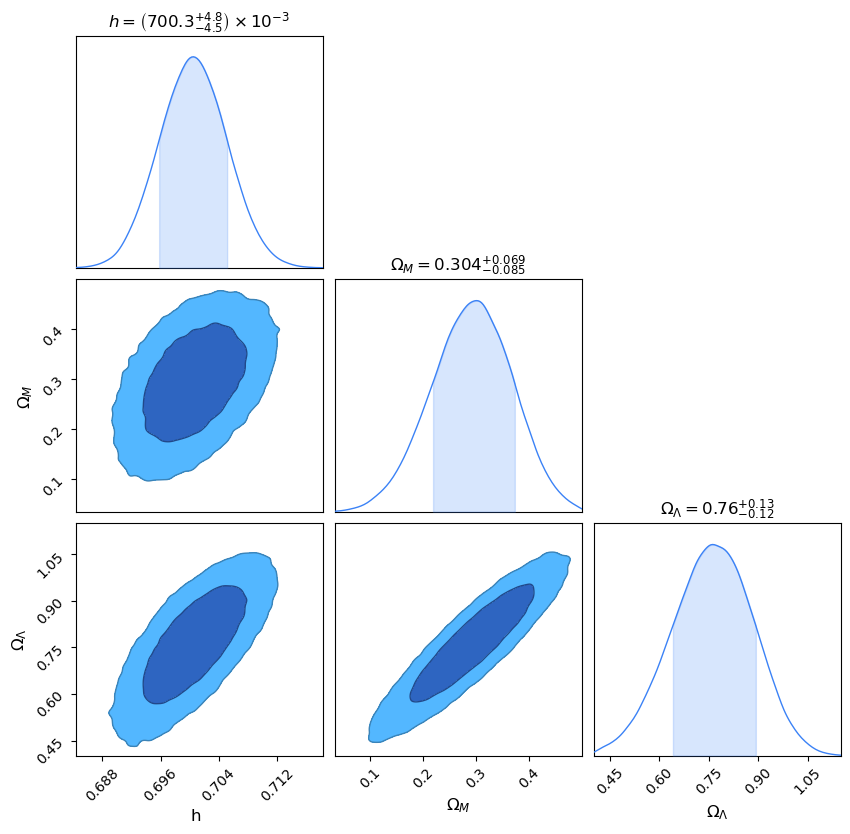

In [49]:
df1 = pd.DataFrame(flat_samples, columns = ['h', '$\Omega_M$', '$\Omega_\Lambda$'])
c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour"))
fig = c.plotter.plot()

In [50]:
### SAVE RESULTS ####
df1.to_csv("h_omega_m_omega_l-curved_universe_EMCEE.csv", index=False)

#### Covariance $\chi^2$

In [151]:
def log_prior(theta):
    h, omega_m, omega_l = theta
    if 0.5 < h < 0.8 and 0.0 < omega_m < 1.0 and 0.0 < omega_l < 2.0:  # Prior for sigma must be positive
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

def log_posterior(theta, data, inv_cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_covariance_h_vs_om_m_vs_om_l_open_lCDM(theta, data, inv_cov)

In [157]:
data = df

# Number of dimensions (h, omega_m, omega_l)
ndim = 3

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 9

# Initial positions of the walkers (random guesses)
initial_h = np.random.uniform(0.6, 0.8, nwalkers)  # Omega_m
initial_omega_m = np.random.uniform(0.2, 0.4, nwalkers)  # Omega_m
initial_omega_l = np.random.uniform(0.6, 0.8, nwalkers)

pos = np.array([initial_h, initial_omega_m, initial_omega_l]).T  # Shape (nwalkers, 3)



In [153]:
# Set up the sampler object
# No systematics
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, inv_cov_nosys])



# Run the MCMC for 500 steps
nsteps = 200000
sampler1.run_mcmc(pos, nsteps, progress=True)


# Get the samples from the sampler chain
samples1 = sampler1.get_chain()


/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_26272/3008668361.py:64: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
  0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 200000/200000 [28:12<00:00, 118.17it/s] 


In [158]:
# With systematics
nsteps = 200000

sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, inv_cov_sys])
sampler2.run_mcmc(pos, nsteps, progress=True)
samples2 = sampler2.get_chain()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_26272/3008668361.py:64: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
 77%|███████▋  | 154525/200000 [15:29<04:40, 162.02it/s] /var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_26272/3008668361.py:64: RuntimeWarning: invalid value encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
100%|██████████| 200000/200000 [20:35<00:00, 161.84it/s]


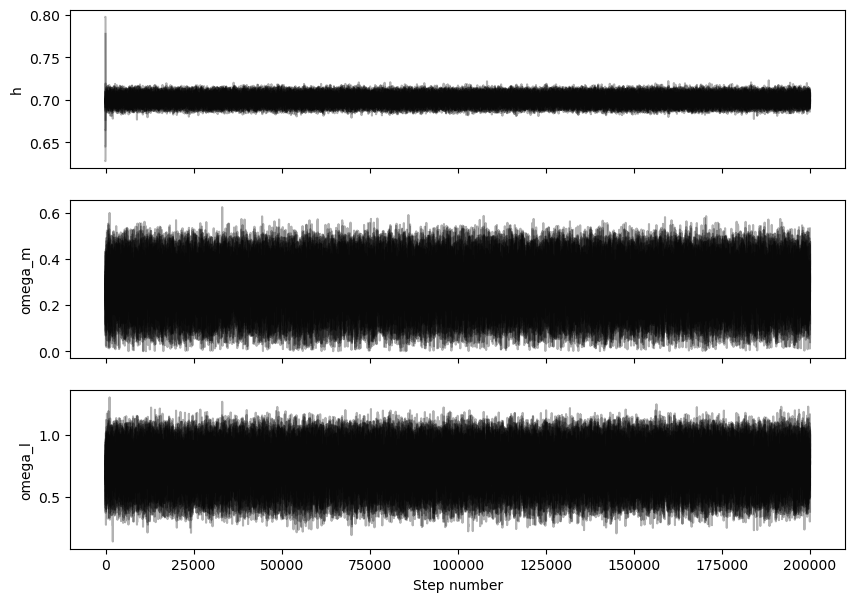

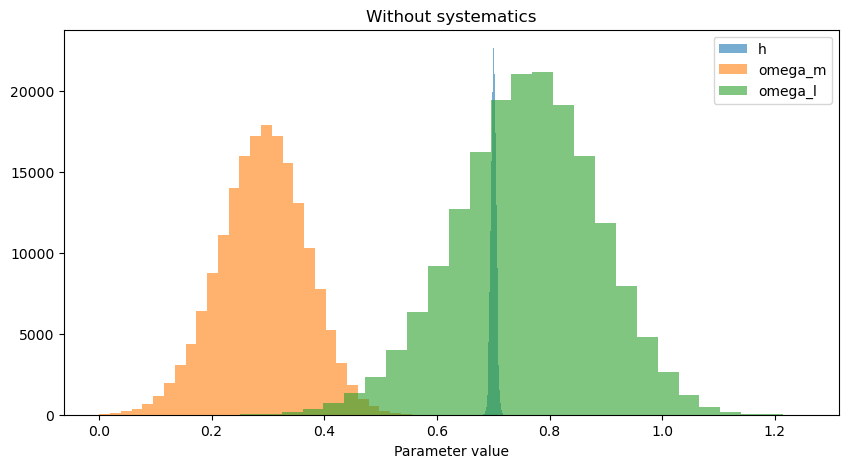

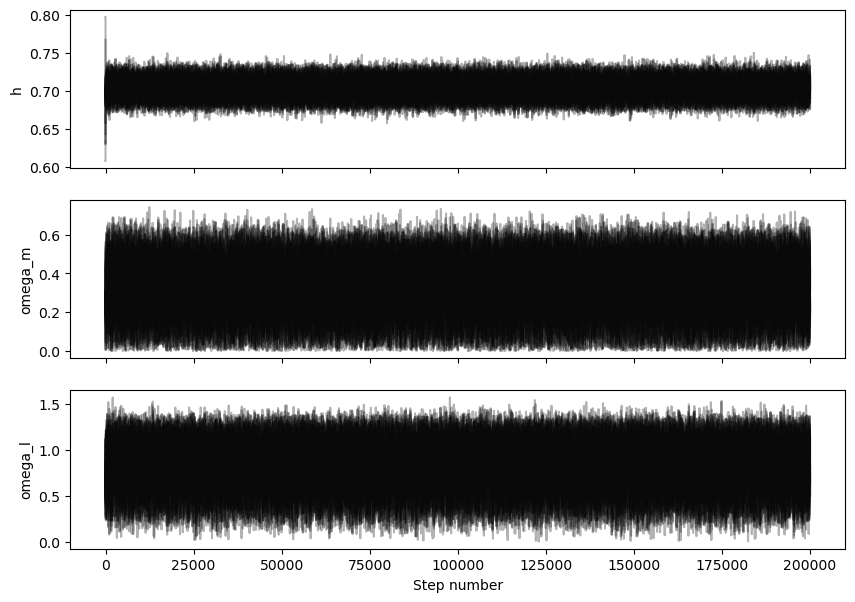

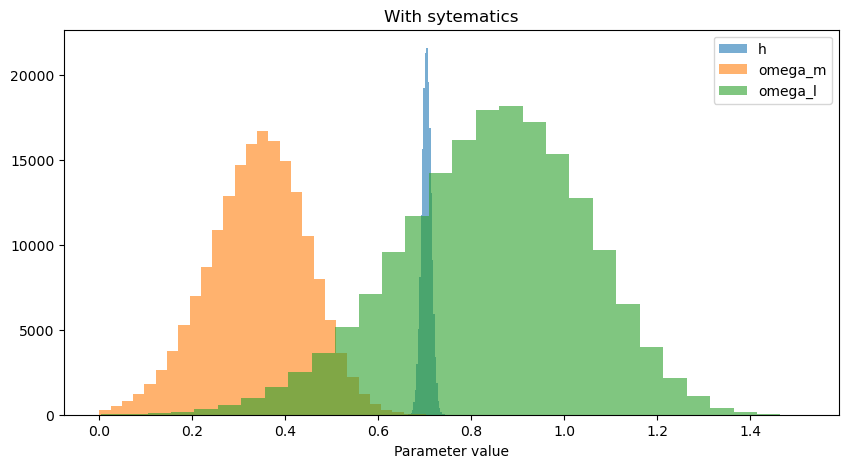

In [159]:
labels = [ "h", "omega_m", "omega_l"]
flat_samples1 = plot_emcee_chains_and_histograms(samples1, sampler1, labels, sys=False)
flat_samples2 = plot_emcee_chains_and_histograms(samples2, sampler2, labels, sys=True)

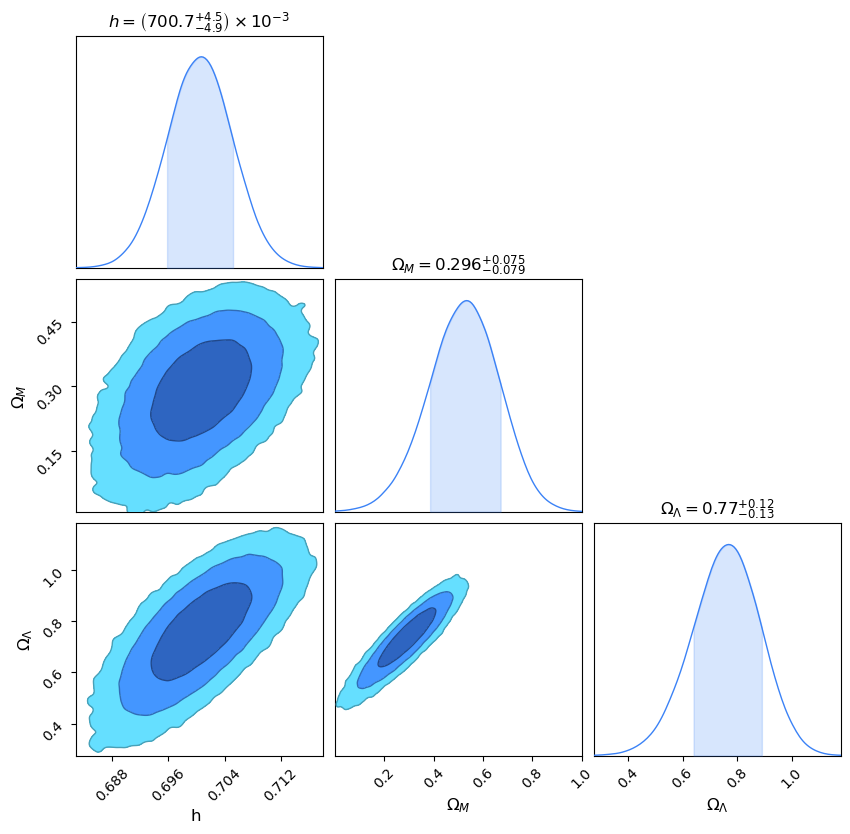

In [160]:
df_1 = pd.DataFrame(flat_samples1, columns = ['h', '$\Omega_M$', '$\Omega_\Lambda$'])
df_2 = pd.DataFrame(flat_samples2, columns = ['h', '$\Omega_M$', '$\Omega_\Lambda$'])

c = ChainConsumer()
c.add_chain(Chain(samples=df_1, name="Without systematics", show_contour_labels=False))
c.set_override(ChainConfig(sigmas=[0, 1, 2, 3]))

fig = c.plotter.plot()

# Customize the axis limits using matplotlib's set_xlim and set_ylim
ax = fig.axes[7]  # Access the  subplot
ax.set_ylim(0.0, 1.5)  # Set limits 
ax.set_xlim(0.0, 1.0)  # Set limits 

#ax.set_title('Test')


# Optional: Save or show the plot
plt.show()

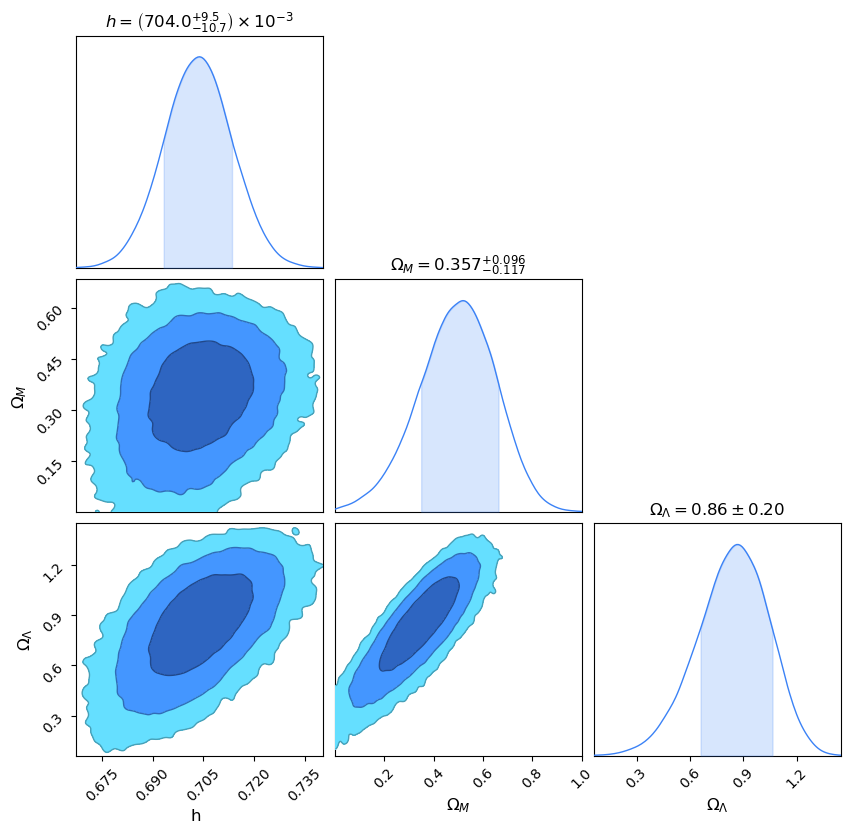

In [105]:
c = ChainConsumer()
c.add_chain(Chain(samples=df_2, name="With systematics", show_contour_labels=False))
c.set_override(ChainConfig(sigmas=[0, 1, 2, 3]))

fig = c.plotter.plot()

# Customize the axis limits using matplotlib's set_xlim and set_ylim
ax = fig.axes[7]  # Access the first subplot
ax.set_ylim(0.0, 1.5)  # Set limits for the second parameter
ax.set_xlim(0.0, 1.0)  # Set limits for the second parameter


# Optional: Save or show the plot
plt.show()

In [161]:
### SAVE RESULTS ####
df_1.to_csv("h_omega_m_omega_l-curved_universe_EMCEE_covariance_nosys.csv", index=False)
df_2.to_csv("h_omega_m_omega_l-curved_universe_EMCEE_covariance_sys.csv", index=False)



### $\Omega_M$ (Flat $\Lambda$ CDM)

#### Simple $\chi^2$ | Analytical Marginalization over h

In [51]:
def log_prior(theta):
    omega_m = theta
    if  0.0 < omega_m < 0.5 :  # Prior for sigma must be positive
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + marginalized_log_likelihood_om_m_flat_lCDM(theta, data)

In [52]:
data = df

# Number of dimensions (h, omega_m, omega_l, w)
ndim = 1

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 3

# Initial positions of the walkers (random guesses)
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m

# Combine initial positions into one array (for 3 parameters)
pos = np.array([ initial_omega_m]).T  # Shape (nwalkers, 3)
# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])

In [53]:
# Run the MCMC 
nsteps = 100000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

100%|██████████| 100000/100000 [01:18<00:00, 1281.06it/s]


Results from paper: Without systematics


<IPython.core.display.Math object>

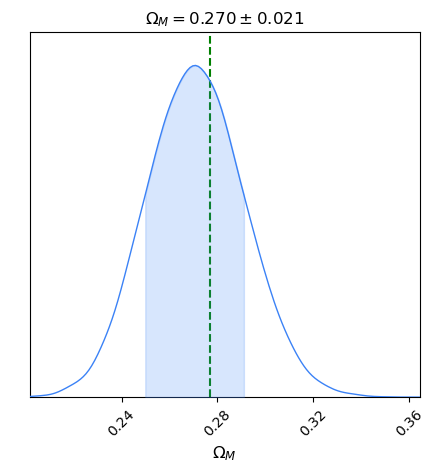

In [55]:
# Flatten the chain (remove burn-in and combine walkers)
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

df1 = pd.DataFrame(flat_samples, columns = ['$\Omega_M$'])

c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour"))
fig = c.plotter.plot()


### Results from paper
omega_m_central = 0.277
omega_m_error_left = 0.021
omega_m_error_right = 0.022
plt.axvline(x=omega_m_central, color="green", linestyle="--", label="Results from paper")

print("Results from paper: Without systematics")
display(Math(r'\Omega_M = 0.295^{{+0.040}}_{{-0.043}}  ') )


In [56]:
### SAVE RESULTS ####
df1.to_csv("omega_m-flat_universe_EMCEE_marginalized.csv", index=False)

#### Covariance $\chi^2$ | Analytical Marginalization over h

In [9]:
def log_prior(theta):
    omega_m = theta
    if 0.02 < omega_m < 0.535:  
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

def log_posterior(theta, data, inv_cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + marginalized_log_likelihood_covariance_om_m_flat_lCDM(theta, data, inv_cov)

In [10]:
data = df

# Number of dimensions (h, omega_m, omega_l)
ndim = 1

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 3

# Initial positions of the walkers (random guesses)
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m

# Combine initial positions into one array (for 3 parameters)
pos = np.array([ initial_omega_m]).T  # Shape (nwalkers, 1)

# Set up the sampler object
# No systematics
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, inv_cov_nosys])



In [11]:
# Run the MCMC for 500 steps
nsteps = 200000
sampler1.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples1 = sampler1.get_chain()



  0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 200000/200000 [14:31<00:00, 229.54it/s]


In [19]:
# With systematics
nsteps = 400000

sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, inv_cov_sys])
sampler2.run_mcmc(pos, nsteps, progress=True)
samples2 = sampler2.get_chain()

  0%|          | 0/400000 [00:00<?, ?it/s]

100%|██████████| 400000/400000 [26:54<00:00, 247.76it/s]


In [20]:
# Flatten the chain (remove burn-in and combine walkers)
flat_samples1 = sampler1.get_chain(discard=1000, thin=10, flat=True)
flat_samples2 = sampler2.get_chain(discard=2000, thin=10, flat=True)

df_1 = pd.DataFrame(flat_samples1, columns = ['$\Omega_M$'])
df_2 = pd.DataFrame(flat_samples2, columns = ['$\Omega_M$'])

Results from paper: (without systematics)


<IPython.core.display.Math object>

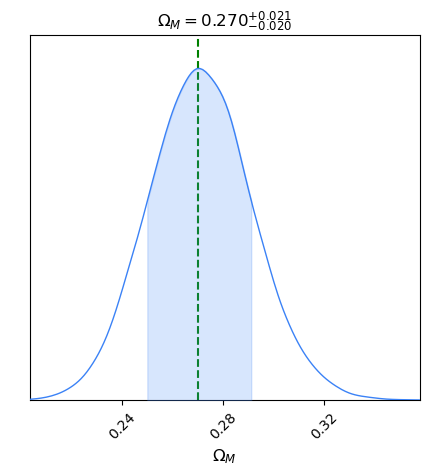

In [21]:
c = ChainConsumer()
c.add_chain(Chain(samples=df_1, name="Without systematics", show_contour_labels=False))
fig = c.plotter.plot()


### Results from paper
omega_m_central = 0.270
plt.axvline(x=omega_m_central, color="green", linestyle="--", label="Results from paper")
#plt.legend()
print("Results from paper: (without systematics)")
display(Math(r'\Omega_M = 0.270^{{+0.021}}_{{-0.021}}  ') )


Results from paper: (without systematics)


<IPython.core.display.Math object>

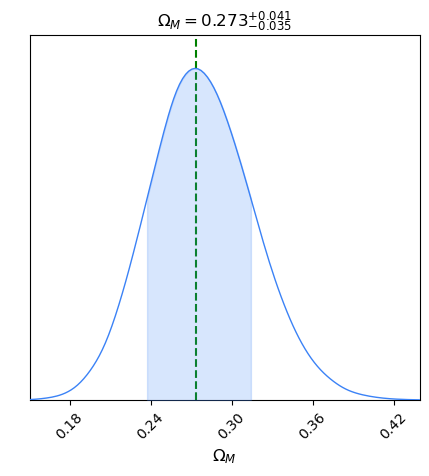

In [22]:
c = ChainConsumer()
c.add_chain(Chain(samples=df_2, name="With systematics", show_contour_labels=False))
fig = c.plotter.plot()

### Results from paper
omega_m_central = 0.274
plt.axvline(x=omega_m_central, color="green", linestyle="--", label="Results from paper")
#plt.legend()
print("Results from paper: (without systematics)")
display(Math(r'\Omega_M = 0.274^{{+0.040}}_{{-0.037}}  ') )


In [136]:
### SAVE RESULTS ####
df_1.to_csv("omega_m-flat_universe_EMCEE_marginalized_covariance_nosys.csv", index=False)
df_2.to_csv("omega_m-flat_universe_EMCEE_marginalized_covariance_sys.csv", index=False)

### $\Omega_M$ vs $\omega$ (Flat $\omega$ CDM)

#### Simple $\chi^2$ | Delta prior over h

In [65]:
def log_prior(theta):
    omega_m, w = theta
    if 0.02 < omega_m < 0.535 and -1.75 < w < -0.25:
        return 0
    return -np.inf  # Reject invalid sigma values

def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_om_m_vs_w_fixed_h_flat_wCDM(theta, data)

In [66]:
data = df

# Number of dimensions (h, omega_m, omega_l, w)
ndim = 2

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 6

# Initial positions of the walkers (random guesses)
#initial_guesses = np.random.uniform(low=0.1, high=1, size=(nwalkers, ndim))
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m
initial_w = np.random.uniform(-1.5, -0.5, nwalkers)      # w

# Combine initial positions into one array (for 3 parameters)
pos = np.array([ initial_omega_m, initial_w]).T  # Shape (nwalkers, 3)

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])

In [67]:
# Run the MCMC for 500 steps
nsteps = 100000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_52235/3008668361.py:64: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
100%|██████████| 100000/100000 [02:20<00:00, 710.87it/s]


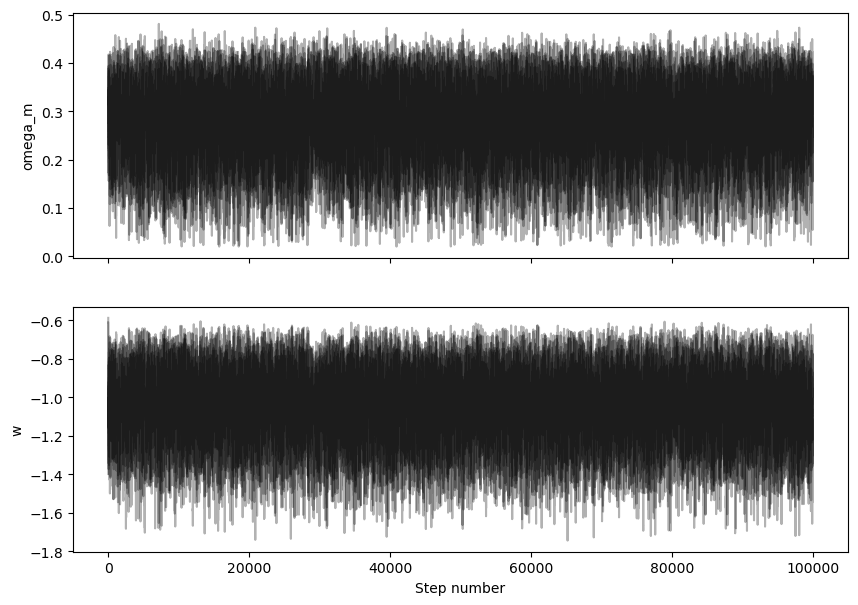

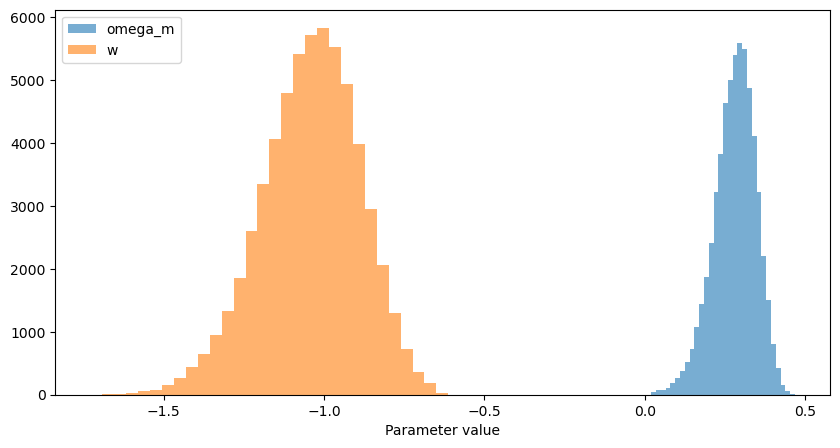

In [68]:
labels = [ "omega_m", "w"]
flat_samples = plot_emcee_chains_and_histograms(samples, sampler, labels)

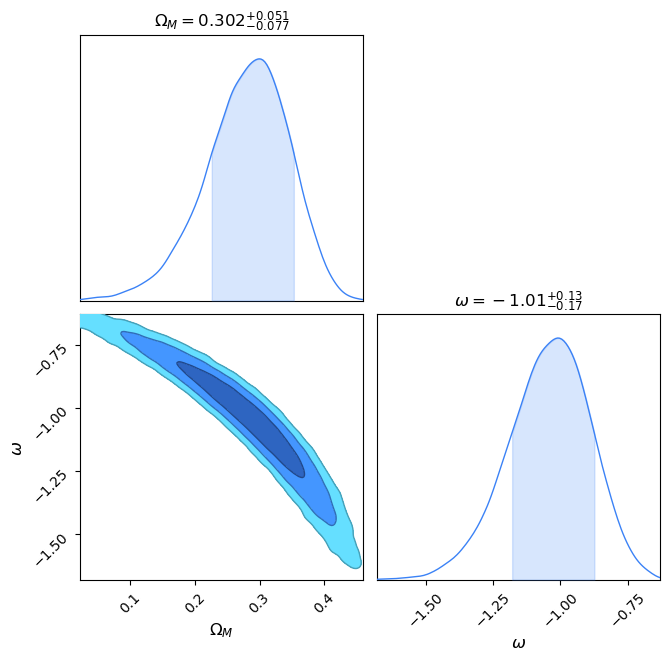

In [69]:
df1 = pd.DataFrame(flat_samples, columns = ['$\Omega_M$', '$\omega$'])
c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour", show_contour_labels=False))
c.set_override(ChainConfig(sigmas=[0, 1, 2, 3]))
fig = c.plotter.plot()

In [70]:
### SAVE RESULTS ####
df1.to_csv("w_omega_m-EMCEE_strict_prior.csv", index=False)

#### Simple $\chi^2$ | Analytical Marginalization over h

In [71]:
def log_prior(theta):
    omega_m, w = theta
    if 0.02 < omega_m < 0.535 and -1.75 < w < -0.25:
        return 0
    return -np.inf  # Reject invalid sigma values

def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + marginalized_log_likelihood_om_m_vs_w_flat_wCDM(theta, data)


In [72]:
data = df

# Number of dimensions (h, omega_m, omega_l, w)
ndim = 2

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 6

# Initial positions of the walkers (random guesses)
#initial_guesses = np.random.uniform(low=0.1, high=1, size=(nwalkers, ndim))
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m
initial_w = np.random.uniform(-1.5, -0.5, nwalkers)      # w

# Combine initial positions into one array (for 3 parameters)
pos = np.array([ initial_omega_m, initial_w]).T  # Shape (nwalkers, 3)

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])

In [73]:
# Run the MCMC 
nsteps = 100000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

100%|██████████| 100000/100000 [02:21<00:00, 706.81it/s]


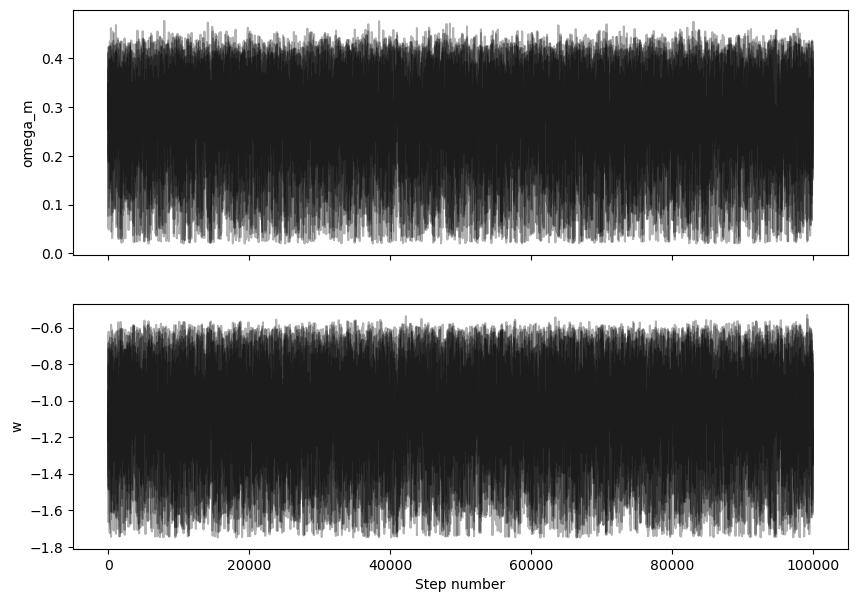

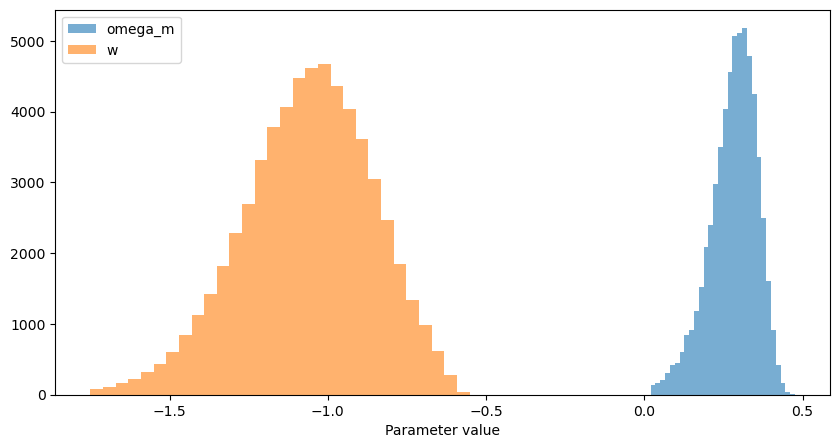

In [74]:
labels = [ "omega_m", "w"]
flat_samples = plot_emcee_chains_and_histograms(samples, sampler, labels)

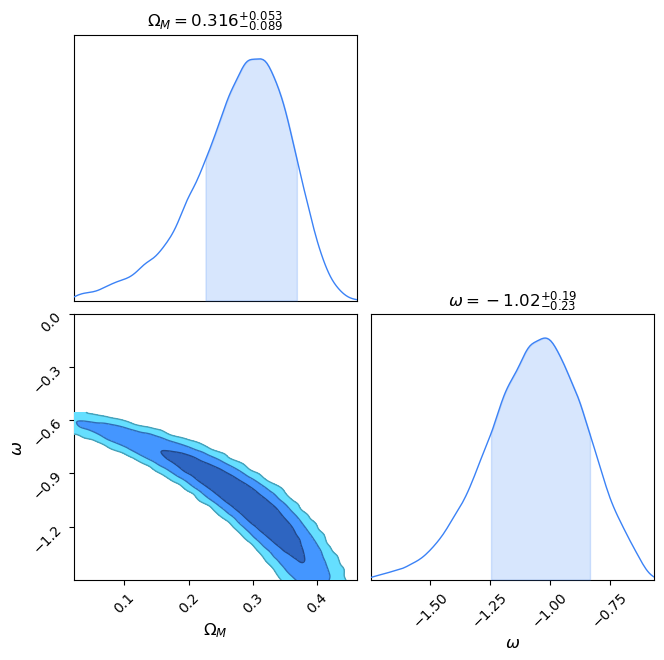

In [75]:
df1 = pd.DataFrame(flat_samples, columns = ['$\Omega_M$', '$\omega$'])
c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour", show_contour_labels=False))
c.set_override(ChainConfig(sigmas=[0, 1, 2, 3]))
fig = c.plotter.plot()

# Customize the axis limits using matplotlib's set_xlim and set_ylim
ax = fig.axes[2]  # Access the first subplot
ax.set_ylim(-1.5, 0.0)  # Set limits for the second parameter

# Optional: Save or show the plot
plt.show()

In [76]:
### SAVE RESULTS ####
df1.to_csv("w_omega_m-EMCEE_marginalized.csv", index=False)

#### Covariance $\chi^2$ | Analytical Marginalization over h

In [162]:
def log_prior(theta):
    omega_m, w = theta
    if 0.0 < omega_m < 1.0 and -3.0 < w < 0.:  
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

def log_posterior(theta, data, inv_cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + marginalized_log_likelihood_covariance_om_m_vs_w_flat_wCDM(theta, data, inv_cov)

In [163]:
data = df

# Number of dimensions (omega_m, w)
ndim = 2

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 6

# Initial positions of the walkers (random guesses)
#initial_guesses = np.random.uniform(low=0.1, high=1, size=(nwalkers, ndim))
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m
initial_w = np.random.uniform(-1.5, -0.5, nwalkers)      # w

# Combine initial positions into one array (for 3 parameters)
pos = np.array([ initial_omega_m, initial_w]).T  # Shape (nwalkers, 3)

# Run the MCMC 
nsteps = 200000

In [164]:
# Set up the sampler object
# No systematics
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, inv_cov_nosys])
sampler1.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples1 = sampler1.get_chain()

100%|██████████| 200000/200000 [17:53<00:00, 186.28it/s]


In [165]:
# With systematics
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, inv_cov_sys])
sampler2.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples2 = sampler2.get_chain()

  0%|          | 2/200000 [00:00<2:48:17, 19.81it/s]

100%|██████████| 200000/200000 [18:52:32<00:00,  2.94it/s]     


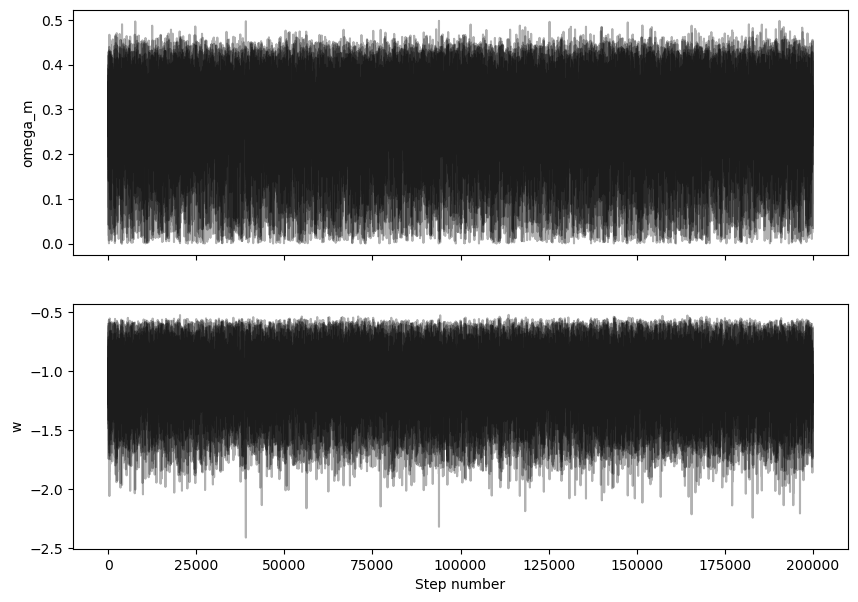

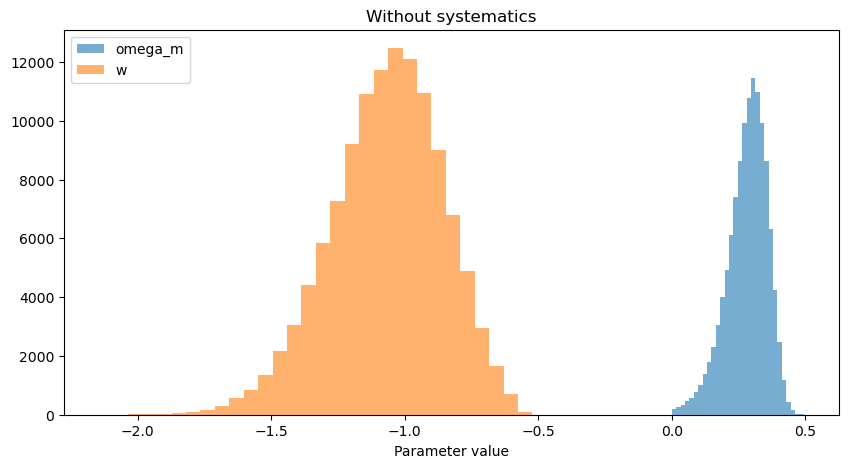

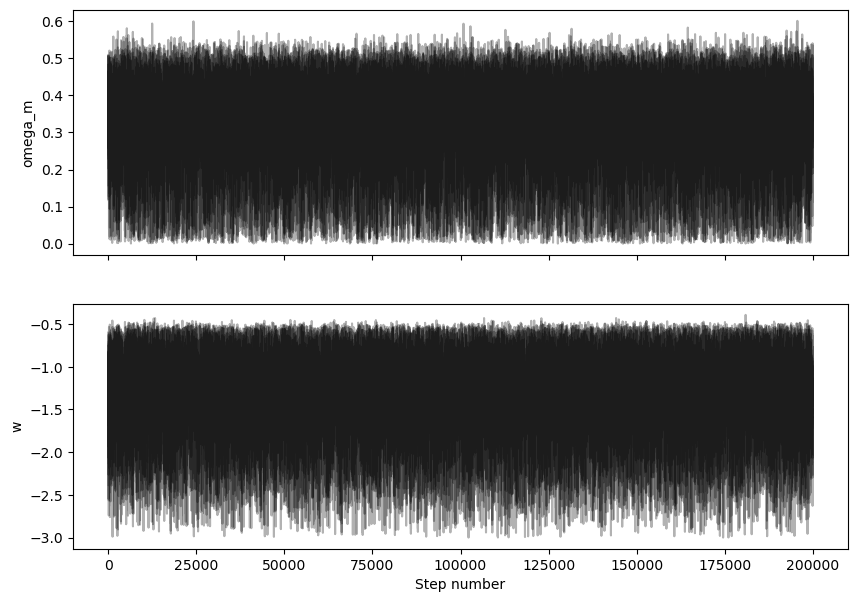

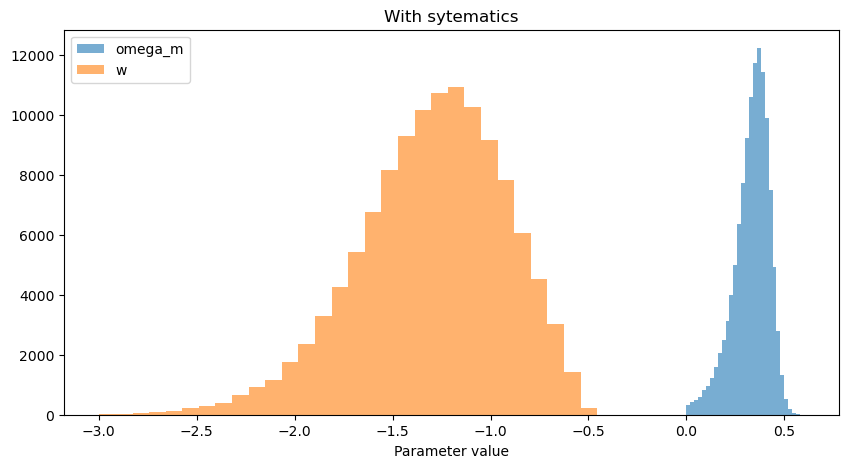

In [166]:
labels = [ "omega_m", "w"]
flat_samples1 = plot_emcee_chains_and_histograms(samples1, sampler1, labels, sys=False)
flat_samples2 = plot_emcee_chains_and_histograms(samples2, sampler2, labels, sys=True)

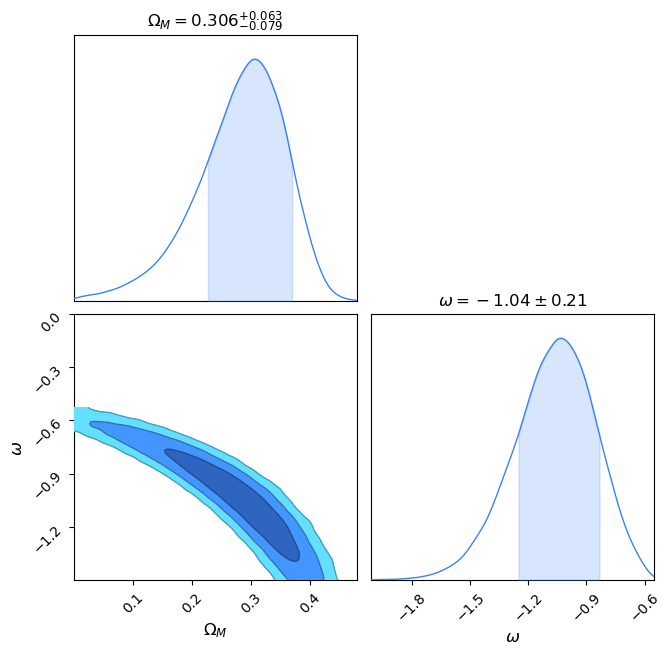

'\n### Results from paper\nomega_m_central = 0.296\n#plt.axvline(x=omega_m_central, color="green", linestyle="--", label="Results from paper")\n#plt.legend()\nprint("Results from paper:")\ndisplay(Math(r\'\\Omega_M = 0.296^{{+0.102}}_{{-0.180}} \\ \\omega = -1.001^{{+0.348}}_{{-0.398}}\') )'

In [167]:
df_1 = pd.DataFrame(flat_samples1, columns = ['$\Omega_M$', '$\omega$'])
c = ChainConsumer()
c.add_chain(Chain(samples=df_1, name="Without systematics", show_contour_labels=False))
c.set_override(ChainConfig(sigmas=[0, 1, 2, 3]))
#c.add_truth(Truth(location={"$\Omega_M$": 0, "$\omega$": 5}, color="#500724"))
#c.plotter.plot(extents={"$\omega$": (-1.5,0.0)})

fig = c.plotter.plot()

# Customize the axis limits using matplotlib's set_xlim and set_ylim
ax = fig.axes[2]  # Access the first subplot
ax.set_ylim(-1.5, 0.0)  # Set limits for the second parameter

# Optional: Save or show the plot
plt.show()
'''
### Results from paper
omega_m_central = 0.296
#plt.axvline(x=omega_m_central, color="green", linestyle="--", label="Results from paper")
#plt.legend()
print("Results from paper:")
display(Math(r'\Omega_M = 0.296^{{+0.102}}_{{-0.180}} \\ \omega = -1.001^{{+0.348}}_{{-0.398}}') )'''

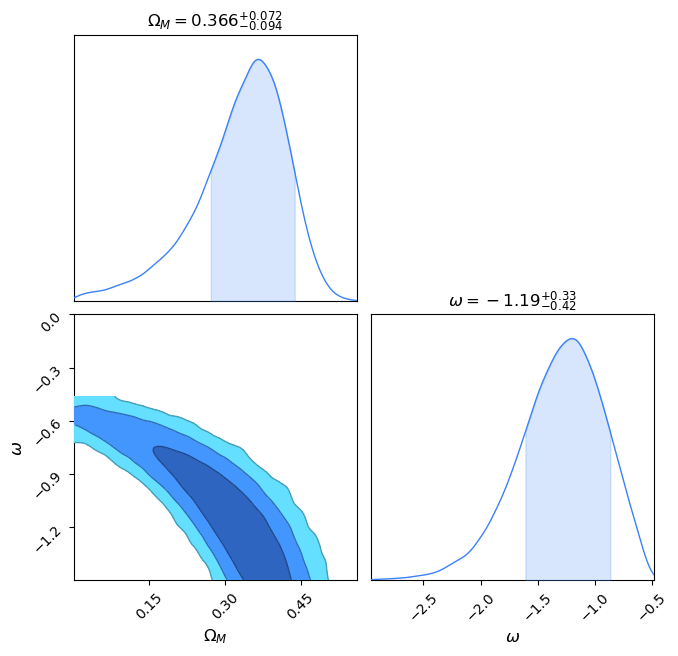

In [168]:
df_2 = pd.DataFrame(flat_samples2, columns = ['$\Omega_M$', '$\omega$'])
c = ChainConsumer()
c.add_chain(Chain(samples=df_2, name="With systematics", show_contour_labels=False))
c.set_override(ChainConfig(sigmas=[0, 1, 2, 3]))
#c.add_truth(Truth(location={"$\Omega_M$": 0, "$\omega$": 5}, color="#500724"))
#c.plotter.plot(extents={"$\omega$": (-1.5,0.0)})

fig = c.plotter.plot()

# Customize the axis limits using matplotlib's set_xlim and set_ylim
ax = fig.axes[2]  # Access the first subplot
ax.set_ylim(-1.5, 0.0)  # Set limits for the second parameter

# Optional: Save or show the plot
plt.show()

In [169]:
### SAVE RESULTS ####
df_1.to_csv("w_omega_m-EMCEE_marginalized_covariance_nosys.csv", index=False)
df_2.to_csv("w_omega_m-EMCEE_marginalized_covariance_sys.csv", index=False)

### $h$ vs $\Omega_M$ vs $\Omega_\Lambda$ vs $\omega$ (Open $\omega$ CDM)

In [19]:
# Define the log prior
def log_prior(theta):
    h, omega_m, omega_l, w = theta
    #if 0.65 < h < 0.75 and  0.02 < omega_m < 0.535 and 0. < omega_l < 1.5 and -2 < w < 0:  
    if 0.65 < h < 0.75 and omega_m > 0 and omega_l > -1.0 and w < 0.0:  
        return 0  # Flat prior
    return -np.inf  # Reject invalid parameter values

def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_h_vs_om_m_vs_om_l_vs_w_open_wCDM(theta, data)


In [20]:
data = df

# Number of dimensions (h, omega_m, omega_l, w)
ndim = 4

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 15

# Initial positions of the walkers (random guesses)
initial_h = np.random.uniform(0.65, 0.75, nwalkers)         # h (Hubble parameter)
initial_omega_m = np.random.uniform(0.25, 0.35, nwalkers)  # Omega_m
initial_omega_l = np.random.uniform(0.68, 0.72, nwalkers)  # Omega_l
initial_w = np.random.uniform(-1.2, -0.8, nwalkers)      # w

# Combine initial positions into one array (for 3 parameters)
pos = np.array([initial_h, initial_omega_m, initial_omega_l, initial_w]).T  

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])

In [21]:
# Run the MCMC 
nsteps = 200000
sampler.reset()
sampler.run_mcmc(pos, nsteps, progress=True, store=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_45048/3008668361.py:64: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 423/200000 [00:01<10:57, 303.68it/s]/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_45048/3008668361.py:43: RuntimeWarning: invalid value encountered in sqrt
  d_C = lambda omega_m, omega_lambda, omega_k, w, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda * (1 + z)**(3 * (1 + w)) + omega_r * (1+z)**4)
  0%|          | 579/200000 [00:02<10:57, 303.32it/s]/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_45048/3008668361.py:64: RuntimeWarning: invalid value encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
100%|██████████| 200000/200000 [10:52<00:00, 306.50it/s]


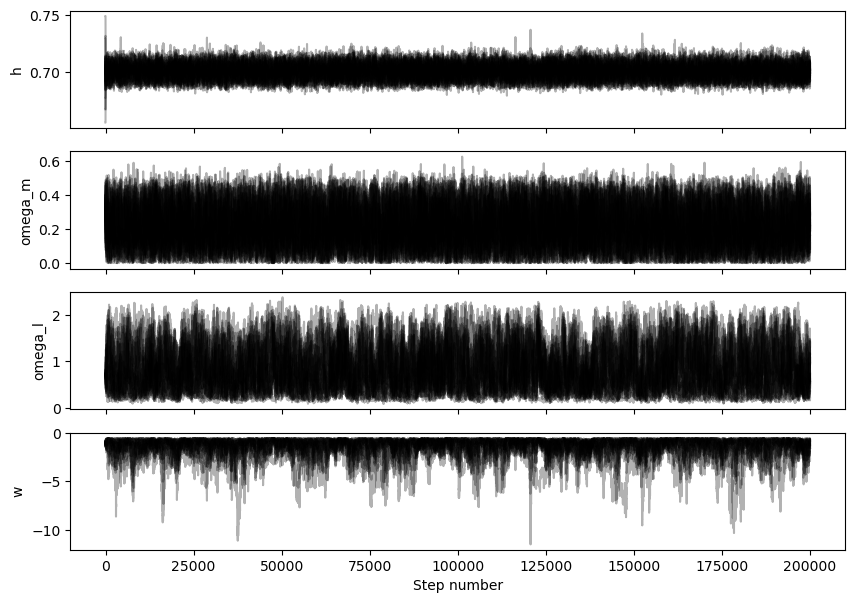

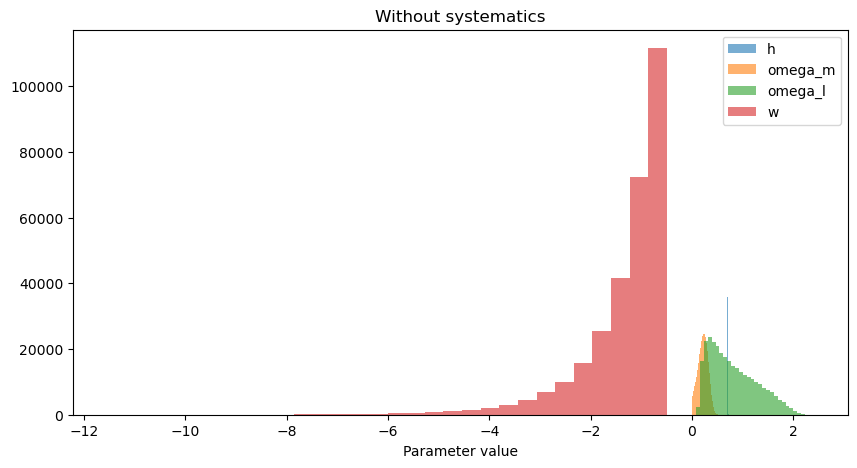

In [22]:
labels = [ "h", "omega_m", "omega_l", "w"]
flat_samples = plot_emcee_chains_and_histograms(samples, sampler, labels)

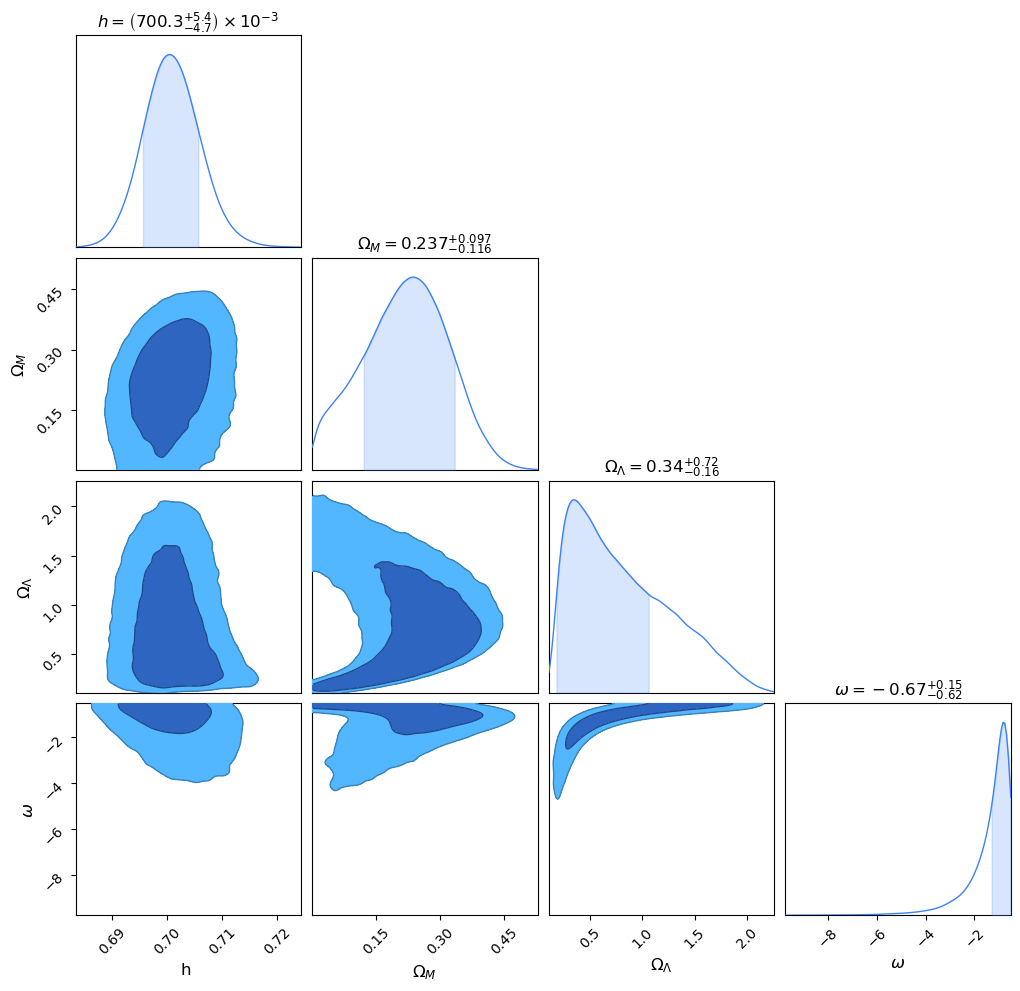

In [23]:
df1 = pd.DataFrame(flat_samples, columns = ['h', '$\Omega_M$', '$\Omega_\Lambda$', '$\omega$'])
c = ChainConsumer()
om_m_true = 0.281
w_true = -1.007
h_true = 0.7
om_l_true = 0.705
c.add_chain(Chain(samples=df1, name="An Example Contour", truths=[h_true, om_m_true, om_l_true, w_true]))
fig = c.plotter.plot()

In [24]:
### SAVE RESULTS ####
df1.to_csv("h_omega_m_omega_l_w-EMCEE_open_wCDM.csv", index=False)

## Truncated Dataset

###  $h$ vs $\Omega_M$ vs $\Omega_\Lambda$ 


In [10]:
def log_prior(theta):
    h, omega_m, omega_l = theta
    if 0.5 < h < 0.8 and 0.0 < omega_m < 1.0 and 0.4 < omega_l < 1.5:  
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_h_vs_om_m_vs_om_l_open_lCDM(theta, data)

In [11]:
data2 = filtered_df

# Number of dimensions (h, omega_m, omega_l)
ndim = 3

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 9

# Initial positions of the walkers (random guesses)
initial_omega_m = np.random.uniform(0.2, 0.4, nwalkers)  # Omega_m
initial_omega_l = np.random.uniform(0.6, 0.8, nwalkers)
initial_h = np.random.uniform(0.65, 0.75, nwalkers)  # Omega_m

pos = np.array([ initial_h, initial_omega_m, initial_omega_l ]).T  # Shape (nwalkers, 3)

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data2]) # Truncated Data 

NameError: name 'filtered_df' is not defined

In [114]:
# Run the MCMC 
nsteps = 100000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_52235/3008668361.py:64: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [03:01<00:00, 549.72it/s]


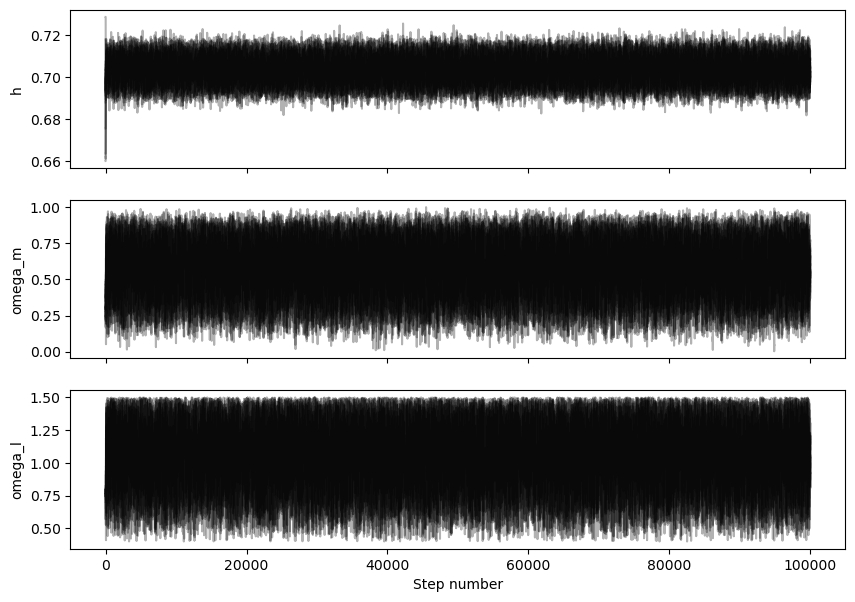

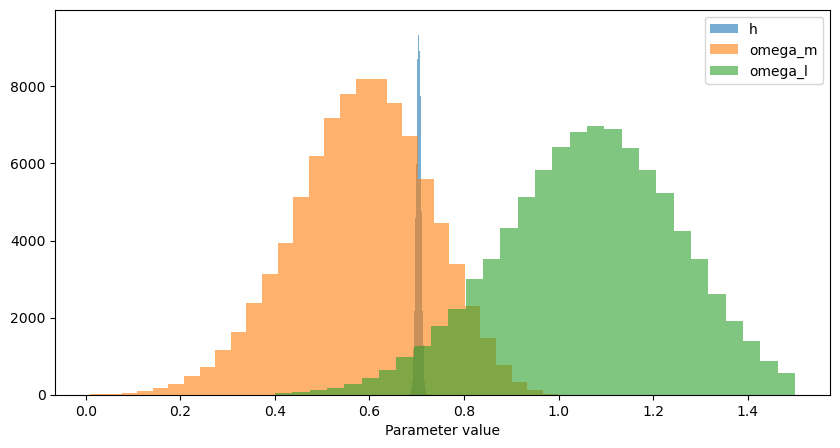

In [115]:
# Plot the walker chains for each parameter
labels = [ "h", "omega_m", "omega_l"]
flat_samples = plot_emcee_chains_and_histograms(samples, sampler, labels)

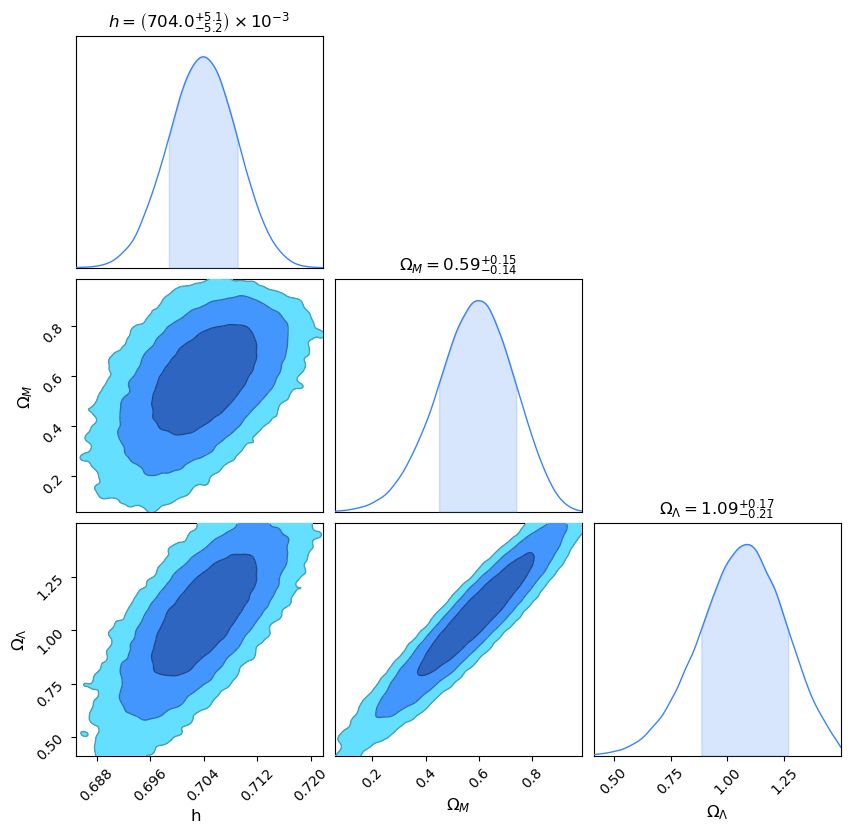

In [118]:
#df1 = pd.DataFrame(flat_samples1, columns = ['h', '$\Omega_M$', '$\Omega_\Lambda$'])
df2 = pd.DataFrame(flat_samples, columns = ['h', '$\Omega_M$', '$\Omega_\Lambda$'])

c = ChainConsumer()
c.add_chain(Chain(samples=df2, name="Truncated Data", show_contour_labels=False))

c.set_override(ChainConfig(sigmas=[0, 1, 2, 3]))
#c.add_truth(Truth(location={"A": 0, "B": 5}, color="#500724"))

fig = c.plotter.plot()

In [119]:
### SAVE RESULTS ####

df1.to_csv("Malmquist_Bias-h_omega_m_omega_l-curved_universe_EMCEE.csv", index=False)

# Play with data

### Effect of Malmquist bias on original data

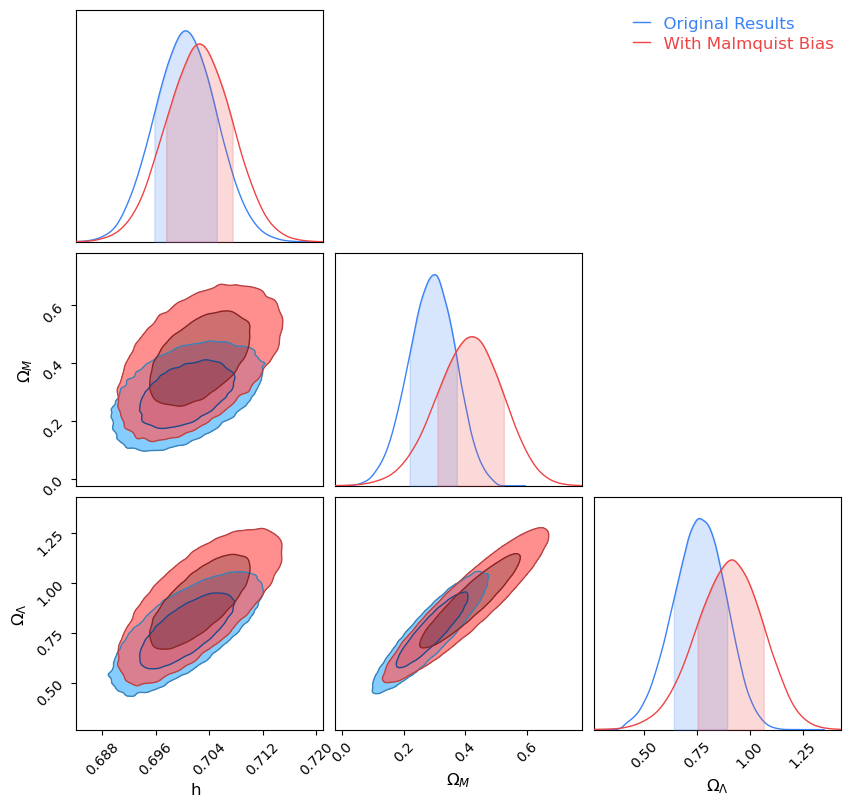

In [121]:
df2 = pd.read_csv("Malmquist_Bias-h_omega_m_omega_l-curved_universe_EMCEE.csv") 
df1 = pd.read_csv("h_omega_m_omega_l-curved_universe_EMCEE.csv") 

c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="Original Results", color = "blue"))
c.add_chain(Chain(samples=df2, name="With Malmquist Bias", color = "red"))
fig = c.plotter.plot()


/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_52235/3008668361.py:64: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25


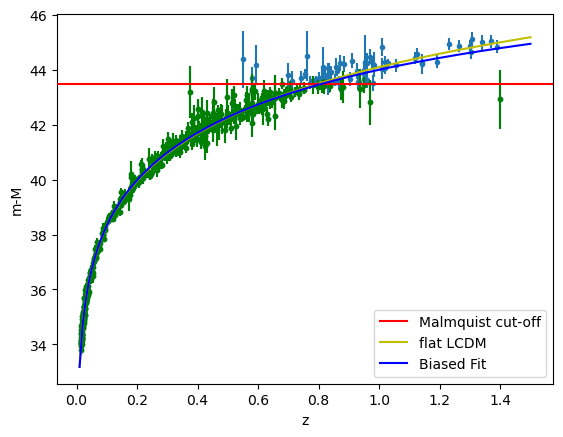

In [125]:
plt.errorbar(df['redshift'], df['magnitude'], yerr=df['error_magnitude'], fmt='.', zorder=1)
plt.errorbar(filtered_df['redshift'], filtered_df['magnitude'], yerr=filtered_df['error_magnitude'], fmt='.', color='green', zorder=2)#, alpha=0.5)
plt.axhline(y = malm_cut, color = 'r', linestyle = '-', zorder=4, label='Malmquist cut-off') 
#plt.xscale('log')
plt.xlabel("z")
plt.ylabel("m-M")

# Model Universe: omega_M ~ 0.3, Omega_Lambda ~ 0.7
z_array = df['redshift'].to_numpy()
x = np.linspace(0, 1.5, 150)
flat_matter_cosmo = distance_modulus(0.7, x, 0.3, 0.69)
test = distance_modulus(0.704, x, 0.59, 1.09)  ## Constraints from Truncated Data
#func_flat_matter_cosmo = interp1d(x, flat_matter_cosmo)
#flat_matter_cosmo = func_flat_matter_cosmo(df['redshift'])
plt.plot(x, flat_matter_cosmo, '-y' ,label='flat LCDM', zorder=3)
plt.plot(x, test, '-b' ,label='Biased Fit', zorder=5)

plt.legend(loc='lower right')

In [17]:
### Check Likelihood for the results
o_m = 0.59
o_l = 1.09
h = 0.704
z = np.linspace(0, 2, 1000)
z_array1 = filtered_df['redshift'].to_numpy()
mag_array1 =  filtered_df['magnitude'].to_numpy()
mag_err1 = filtered_df['error_magnitude'].to_numpy()
model1 = distance_modulus(h, z, o_m, o_l)
func_model1 = interp1d(z, model1)
model2 = func_model1(z_array1)

chi2 = np.sum(chi_square(model2, mag_array1, mag_err1))
like = np.exp(-chi2/2)
chi2


/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_93644/3008668361.py:64: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25


459.90244428334563

In [131]:
dof = len(filtered_df) - 3
reduced_chi2 = chi2/dof
reduced_chi2

0.9347610656165561

### $d_L$ vs $z$

In [204]:
z = np.linspace(0, 2, 1000)
# om_m = 0.3 , om_k = 0
dL = d_L(0.7, z, 0.3, 0.69)

print('z:', z.shape)
print('dL:', dL.shape)

z: (1000,)
dL: (1000,)


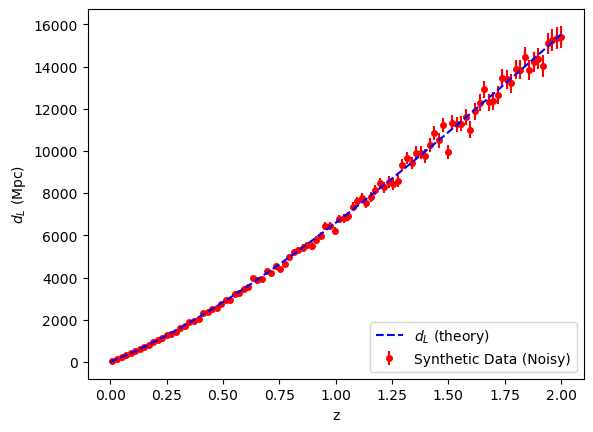

In [205]:
f = interp1d(z, dL) 
'''
random_z = np.random.rand(1, 200)#, size=200)
print('random z', random_z)
print(random_z.shape)
'''
np.random.seed(42)  # for reproducibility
z_values = np.linspace(0.01, 2.0, 100)  # Redshifts from 0.01 to 2.0
d_L_values = f(z_values)

# Generate redshift-dependent errors (e.g., 2% at z = 0.01 to 10% at z = 2)
errors = d_L_values * (0.02 + 0.01 * np.sqrt(z_values))

# Add random noise based on these errors to simulate observational uncertainties
d_L_noisy = d_L_values + np.random.normal(0, errors)



'''

#scaled_noise = noise * (0.1 + 1.0 * z)  # Noise increases as x increases
d_L_ = f(random_z) # scaled_noise  # Data with random variation
#Add random variation to the dummy data
disp = np.random.normal(0, 200, size=random_z.shape)  # Random noise with mean 0 and std dev 2
real_dL = real_dL + disp
# Random errors for the noisy data
error = np.random.uniform(0, 200, size=random_z.shape) #* (1 + 0.3 * z)  # Increasing error bars with x
'''


'''
# dL cuts for O4 and O5
# https://emfollow.docs.ligo.org/userguide/capabilities.html 
malm_cut1, malm_cut2 = 160, 325
plt.axhline(y = malm_cut1, color = 'r', linestyle = '-', zorder=4, label='O4 BNS sensitivity (SNR=8)') 
plt.axhline(y = malm_cut2, color = 'b', linestyle = '-', zorder=4, label='O5 BNS sensitivity (SNR=8)') 

# Variation in dL due to variation in viewing angle
zeta = np.random.uniform(0, np.pi/2, size=z.shape)
dL_view = dL_noisy / np.cos(zeta)'''

plt.plot(z, dL, label='$d_L$ (theory)', zorder=2, color="blue", linestyle="--")
plt.errorbar(z_values, d_L_noisy, yerr=errors, fmt='o', zorder=1, color="red", label="Synthetic Data (Noisy)", markersize=4)
#plt.errorbar(z, dL_view, yerr=error, fmt='.', zorder=1, label='Observed Data ($\zeta = 0\degree - 90\degree$)')
#plt.xscale('log')
'''
# GW170817
z_1 = [0.0098]
dL_1 = [40]
dL_1_err = [8]
plt.errorbar(z_1, dL_1, yerr=dL_1_err, fmt='o', zorder=5, label='GW170817')

# test for viewing angle changes in d_L
z_1 = [0.0098]
func = interp1d(z, dL)
dL_2 = func(z_1) / np.cos(math.radians(29))
dL_2_err = [8]
plt.errorbar(z_1, dL_2, yerr=dL_1_err, fmt='o', zorder=8, label='GW170817 like')'''

plt.legend(loc="lower right")
plt.xlabel("z")
plt.ylabel("$d_L$ (Mpc)")
#plt.title('100 BNS events ')
ax = plt.gca()
#ax.set_ylim(0, 500)
#ax.set_xlim(0, 0.02)

In [206]:
mock_data = pd.DataFrame({'redshift':z_values, 'magnitude':d_L_values, 'error_magnitude':errors})
mock_data


redshift     magnitude  error_magnitude
0   0.010000     43.156134         0.906279
1   0.030101    131.871313         2.866218
2   0.050202    223.165900         4.963339
3   0.070303    316.983160         7.180135
4   0.090404    413.266926         9.507919
..       ...           ...              ...
95  1.919596  14756.071088       499.566026
96  1.939697  14945.981745       507.076813
97  1.959798  15136.276923       514.622494
98  1.979899  15326.951716       522.202861
99  2.000000  15518.001325       529.817706

[100 rows x 3 columns]

In [224]:
def log_pri(theta):
    omega_m, omega_l = theta
    if 0.0 < omega_m < 0.5 and 0.4 < omega_l < 1.0:  
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

def log_like(theta, data):
    omega_m, omega_l = theta
    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()
    z = np.linspace(0, 2, 1000)
    
    model1 = d_L(0.7, z, omega_m, omega_l)
    func_model1 = interp1d(z, model1)
    model2 = func_model1(z_array)
    chi2 = chi_square(model2, mag_array, mag_err)
    chi2 = np.sum(chi2)
    return -chi2/2 

def log_post(theta, data):
    lp = log_pri(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(theta, data)

In [225]:
data = mock_data

# Number of dimensions (h, omega_m)
ndim = 2

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 6

# Initial positions of the walkers (random guesses)
initial_omega_m = np.random.uniform(0.2, 0.4, nwalkers)  # Omega_m
initial_h = np.random.uniform(0.6, 0.8, nwalkers)
initial_omega_l = np.random.uniform(0.6, 0.8, nwalkers)  


pos = np.array([initial_omega_m, initial_omega_l]).T  # Shape (nwalkers, 3)

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=[data])

In [226]:
# Run the MCMC for 500 steps
nsteps = 1000000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

100%|██████████| 1000000/1000000 [19:25<00:00, 857.71it/s]


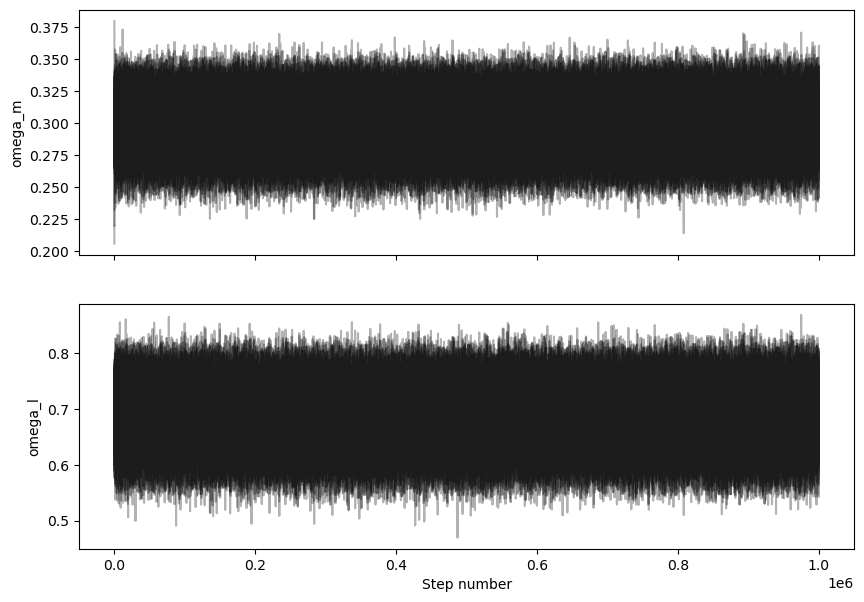

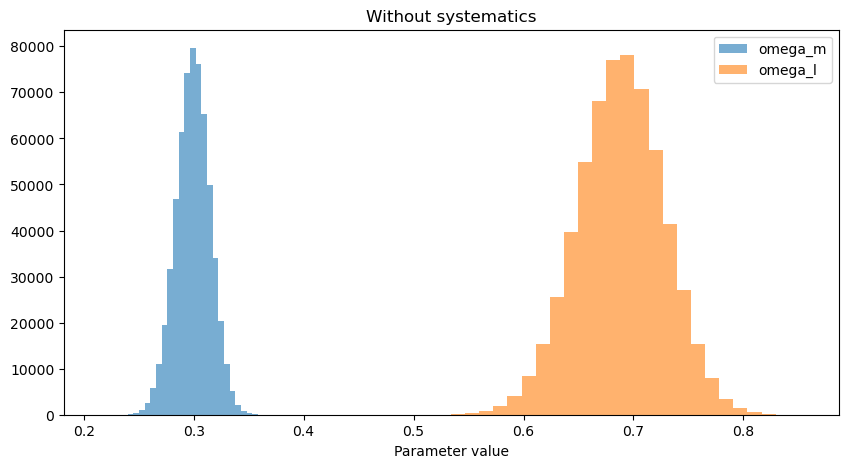

In [227]:
labels = [ "omega_m", "omega_l"]
flat_samples = plot_emcee_chains_and_histograms(samples, sampler, labels)

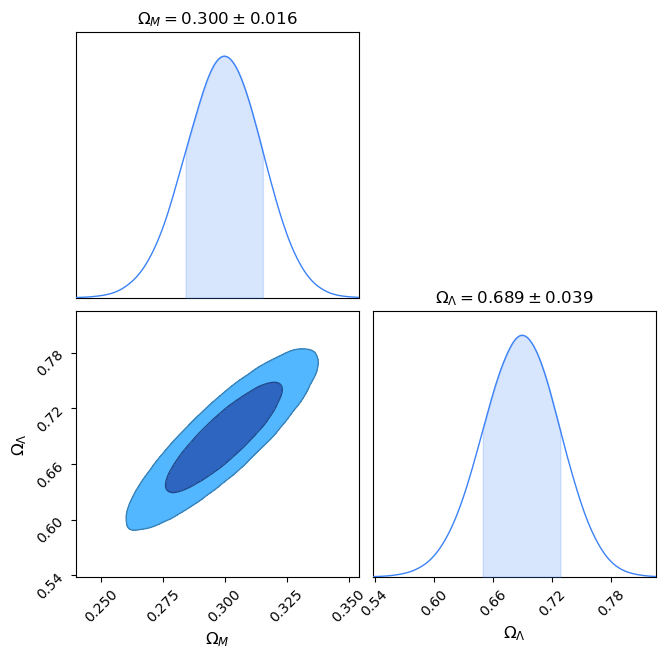

In [229]:
dff = pd.DataFrame(flat_samples, columns = ['$\Omega_M$', '$\Omega_\Lambda$'])
c = ChainConsumer()
c.add_chain(Chain(samples=dff, name="An Example Contour"))
fig = c.plotter.plot()

In [25]:
'''## DL for z=0
model2 = func_model1(0)
model2'''

'## DL for z=0\nmodel2 = func_model1(0)\nmodel2'

In [26]:
'''### Check Likelihood for the results
o_m = 0.59
o_l = 1.09
h = 0.704
z = np.linspace(0, 2, 1000)
z_array1 = filtered_df['redshift'].to_numpy()
mag_array1 =  filtered_df['magnitude'].to_numpy()
mag_err1 = filtered_df['error_magnitude'].to_numpy()
model1 = distance_modulus(h, z, o_m, o_l)
func_model1 = interp1d(z, model1)
model2 = func_model1(z_array1)

chi2 = np.sum(chi_square(model2, mag_array1, mag_err1))
like = np.exp(-chi2/2)
chi2
'''

"### Check Likelihood for the results\no_m = 0.59\no_l = 1.09\nh = 0.704\nz = np.linspace(0, 2, 1000)\nz_array1 = filtered_df['redshift'].to_numpy()\nmag_array1 =  filtered_df['magnitude'].to_numpy()\nmag_err1 = filtered_df['error_magnitude'].to_numpy()\nmodel1 = distance_modulus(h, z, o_m, o_l)\nfunc_model1 = interp1d(z, model1)\nmodel2 = func_model1(z_array1)\n\nchi2 = np.sum(chi_square(model2, mag_array1, mag_err1))\nlike = np.exp(-chi2/2)\nchi2\n"

In [ ]:
from astropy.cosmology import Planck18 as cosmo

# Given luminosity distances in Mpc
luminosity_distances = [1757.52, 3670.27]

# Calculate redshifts corresponding to the given distances
redshifts = [cosmo.z_at_value(cosmo.luminosity_distance, d * 1e6) for d in luminosity_distances]  # Convert Mpc to pc

print(redshifts)